In [235]:
import pandas as pd

In [236]:
data = pd.read_csv("../data/curated/NO_DOMAIN_DATASET.csv")
coast = pd.read_csv("../data/curated/vic_beach_proximity.csv")
schools = pd.read_csv("../data/curated/schools_by_SAL.csv")
tourism = pd.read_csv("../data/curated/victoria_gdp_tourism.csv")
airbnb = pd.read_csv("../data/curated/airbnb_counts.csv")

In [237]:
# get years from 2016-2023
data_train = data
data_train = pd.merge(data_train, tourism, on='year', how='inner')
data_train = pd.merge(data_train, airbnb, left_on='SAL_CODE', right_on='SAL_CODE21', how='left')

data_train.rename(columns={'counts':'airbnb_count'}, inplace=True)

In [238]:
to_exclude = pd.read_csv('../data/landing/filtered_sal_codes.csv')

to_exclude = list(to_exclude['SAL_CODE'])


In [239]:
# also exclude any airport
data_train = data_train[~data_train['SAL_suburb'].str.contains('Airport')]

data_train = data_train[~data_train['SAL_CODE'].isin(to_exclude)]

data_train = data_train[~data_train['SAL_suburb'].str.contains("Ravenhall")]

# Get counts per year
year_counts = data_train['year'].value_counts().sort_index()


In [240]:
cols = ['distance_to_CBD', 'time_to_CBD','distance_to_station', 'time_to_station', 
        'year', 'A Crimes against the person',
       'Average_household_size', 'Average_num_psns_per_bedroom',
       'B Property and deception offences', 'C Drug offences',
       'D Public order and security offences', 'E Justice procedures offences',
       'F Other offences', 'Median_age_persons', 'Median_tot_fam_inc_weekly',
       'Median_tot_hhd_inc_weekly', 'Median_tot_prsnl_inc_weekly', 'Tot_P_P',
        'average_quarterly_count', 'average_weekly_rent',
        'commercial', 'education', 'food_establishments',
       'healthcare', 'industrial', 'public_transport', 'recreation',
       'residential', 'shopping', 'inflation',"SAL_CODE", "median_score", 'average_price',"proximity_to_beach", 'gdp_impact', 'airbnb_count']

data_train = data_train[cols]



In [241]:
import geopandas as gpd

In [242]:
# get data to be divided by area
div_area = ['commercial', 'education', 'food_establishments','healthcare', 'industrial', 'public_transport', 'recreation','residential', 'shopping']

# get SAL codes
sal_boundaries = gpd.read_file('../data/landing/SAL_data/SAL_2021_AUST_GDA2020.shp')
sal_boundaries = sal_boundaries[['SAL_CODE21','AREASQKM21']]

# Filter out non-numeric SAL_CODE21 values
sal_boundaries = sal_boundaries[sal_boundaries['SAL_CODE21'].apply(lambda x: str(x).isdigit())]
sal_boundaries['SAL_CODE21'] = sal_boundaries['SAL_CODE21'].astype(int)

data_train = pd.merge(data_train, sal_boundaries, left_on='SAL_CODE', right_on='SAL_CODE21', how='inner')

# divide by area
for col in div_area:
    data_train[col + ' density'] = data_train[col] / data_train['AREASQKM21']
    data_train.drop(columns=[col], inplace=True)

data_train['pop density'] = data_train['Tot_P_P'] / data_train['AREASQKM21']

data_train = data_train.drop(columns=['AREASQKM21','SAL_CODE21'])

In [243]:
years_interest = list(range(2016, 2030))
interest_rates = [
    1.75,  # 2016
    1.50,  # 2017
    1.50,  # 2018
    1.50,  # 2019
    0.25,  # 2020 (COVID-19 impact, very low rates)
    0.10,  # 2021 (near-zero rates)
    0.35,  # 2022 (start of increase)
    3.10,  # 2023 (rise due to inflation concerns)
    4.00,  # 2024 (projection)
    3.75,  # 2025 (projection)
    3.50,  # 2026 (projection)
    3.25,  # 2027 (projection)
    3.00,  # 2028 (projection)
    2.75   # 2029 (projection)
]

# Creating a DataFrame
interest_rate_table = pd.DataFrame({
    "Year": years_interest,
    "Projected Interest Rate (%)": interest_rates
})

# create df with years and gdp growth rate
gdp_df = pd.DataFrame({
    'year': range(2016, 2030),
    'interest_rate': interest_rates
})

# Merge the GDP growth rate data with the main dataframe on the 'year' column
data_train = pd.merge(data_train, gdp_df, on='year', how='left')

In [244]:
import pandas as pd

# Assuming your DataFrame is called df
# First, ensure that your DataFrame is sorted by 'year'
df = data_train
df = df.sort_values('year')

# Convert 'inflation' rates from percentages to decimals
df['inflation_decimal'] = df['inflation'] / 100

# Create a DataFrame containing all years from 2016 to the maximum year in your data
years = pd.DataFrame({'year': range(2016, df['year'].max() + 1)})

# Merge with the inflation data to ensure all years are included
inflation_data = pd.merge(years, df[['year', 'inflation_decimal']].drop_duplicates(), on='year', how='left')

# Forward-fill any missing inflation rates (if any years are missing)
inflation_data['inflation_decimal'] = inflation_data['inflation_decimal'].fillna(method='ffill')

# Calculate the cumulative inflation factor from 2016 to each year
inflation_data['cumulative_inflation_factor'] = (1 + inflation_data['inflation_decimal']).cumprod()

# Create a dictionary to map years to cumulative inflation factors
cumulative_inflation_dict = inflation_data.set_index('year')['cumulative_inflation_factor'].to_dict()

# Map the cumulative inflation factors back to the original DataFrame
df['cumulative_inflation_factor'] = df['year'].map(cumulative_inflation_dict)


# Update the 'inflation' column to reflect the cumulative effect from 2016
df['inflation'] = df['cumulative_inflation_factor']

# Drop the temporary columns if you no longer need them
df = df.drop(columns=['inflation_decimal', 'cumulative_inflation_factor'])


In [245]:
import numpy as np

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

In [247]:
# combine inflation and gdp growth rate per year:
# Merge the GDP growth rate data with the main dataframe on the 'year' column
inflation_data = pd.merge(inflation_data, gdp_df, on='year', how='left')
inflation_data

year  inflation_decimal  cumulative_inflation_factor  interest_rate
0   2016              0.013                     1.013000           1.75
1   2017              0.021                     1.034273           1.50
2   2018              0.019                     1.053924           1.50
3   2019              0.013                     1.067625           1.50
4   2020              0.022                     1.091113           0.25
5   2021              0.011                     1.103115           0.10
6   2022              0.051                     1.159374           0.35
7   2023              0.070                     1.240530           3.10
8   2024              0.036                     1.285189           4.00
9   2025              0.030                     1.323745           3.75
10  2026              0.027                     1.359486           3.50
11  2027              0.027                     1.396192           3.25
12  2028              0.026                     1.432493           3.00

In [248]:
# inflation affected columns
inflation_affected_cols = ['average_weekly_rent', 'Median_tot_fam_inc_weekly', 'Median_tot_hhd_inc_weekly', 'Median_tot_prsnl_inc_weekly', 'gdp_impact']

# Apply inflation adjustment to the affected columns
for col in inflation_affected_cols:
    df[col + '/inflation'] = df[col] / df['inflation']

    df.drop(columns=[col], inplace=True)

In [249]:

df['gdp_cbd/inflation/beach'] = np.log(df['gdp_impact/inflation']) * df['proximity_to_beach']
df['gdp_cbd/inflation/cbd'] = np.log(df['gdp_impact/inflation']) * df['distance_to_CBD']
df['gpd/inflation/airbnb'] = np.log(df['gdp_impact/inflation']) * df['airbnb_count']

# drop the original columns
df.drop(columns=['gdp_impact/inflation'], inplace=True)

In [250]:
df.drop(columns=['inflation'], inplace=True)

In [251]:
df['year'].max()

2028

In [252]:
# divide by average_household_size to get 'per person' rent
df['average_weekly_rent/inflation/household_size'] = df['average_weekly_rent/inflation'] / (df['Average_household_size'] + 0.01)
df.drop(columns=['average_weekly_rent/inflation'], inplace=True)

In [253]:
import numpy as np

In [254]:
# get crime rate per person
crime_cols = ['A Crimes against the person', 'B Property and deception offences', 'C Drug offences', 'D Public order and security offences', 'E Justice procedures offences', 'F Other offences']

for col in crime_cols:
    df[col + '/per_person'] = df[col] / (df['Tot_P_P'] + 0.01)

    df.drop(columns=[col], inplace=True)

In [255]:
# log data for every column but average weekly rent
for col in df.columns:
    if col not in ['average_weekly_rent/inflation/household_size', 'SAL_CODE', 'year', 'interest_rate']:
        df[col] = df[col].apply(lambda x: np.log(x + 1))

In [256]:
df.to_csv('../data/curated/Processed Data Final.csv', index=False)

In [257]:
target = 'average_weekly_rent/inflation/household_size'

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns

In [259]:
df.dropna(inplace=True)

In [260]:
# remove Nan for target variable
df = df[~df[target].isna()]

In [261]:
max_value = df[target].max()
min_value = df[target].min()

print(f"Maximum value: {max_value}")
print(f"Minimum value: {min_value}")

# remove non numbers (infinity)
df = df[np.isfinite(df[target])]
df = df[~df[target].isna()]

Maximum value: 325.47784049258667
Minimum value: 84.01030699732334


In [262]:
df['year'].max()

2024

In [263]:
df.to_csv("../data/curated/procesed_data.csv", index=False)

df.drop(columns=['Average_household_size'], inplace=True)

In [264]:
df_dropped = df[df['year'].isin([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])]

In [265]:
df_dropped = df_dropped.drop(columns=['SAL_CODE', 'year', 'average_quarterly_count'])

In [266]:
df_dropped.shape

(4221, 35)

In [267]:
#df_dropped = df_dropped.drop("Average_household_size", axis=1)

In [268]:
from sklearn.model_selection import train_test_split

X = df_dropped.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(df_dropped.drop(columns=[target]), df[target], test_size=0.2, random_state=42)



In [269]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the scaled training data
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test set
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression R^2 Score: {r2_lr}")

Linear Regression Mean Squared Error: 256.8410352446435
Linear Regression R^2 Score: 0.7921948028334915


In [270]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the StandardScaler
scaler = StandardScaler()



# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Train the model on the scaled training data
rf_model.fit(X_train, y_train)

# Make predictions on the scaled test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest Mean Squared Error: 66.2858052892247
Random Forest R^2 Score: 0.946369415524479


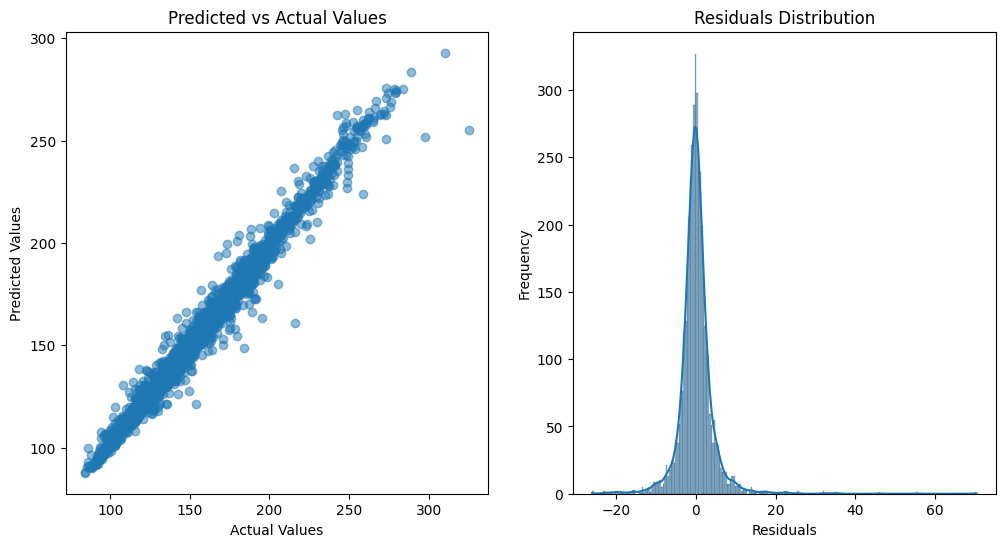

In [271]:
# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y, rf_model.predict(X), alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# Calculate residuals
residuals = y - rf_model.predict(X)

# Plot residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.savefig("../plots/residuals_RF.png")

plt.show()



/opt/anaconda3/envs/ADS/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/ADS/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


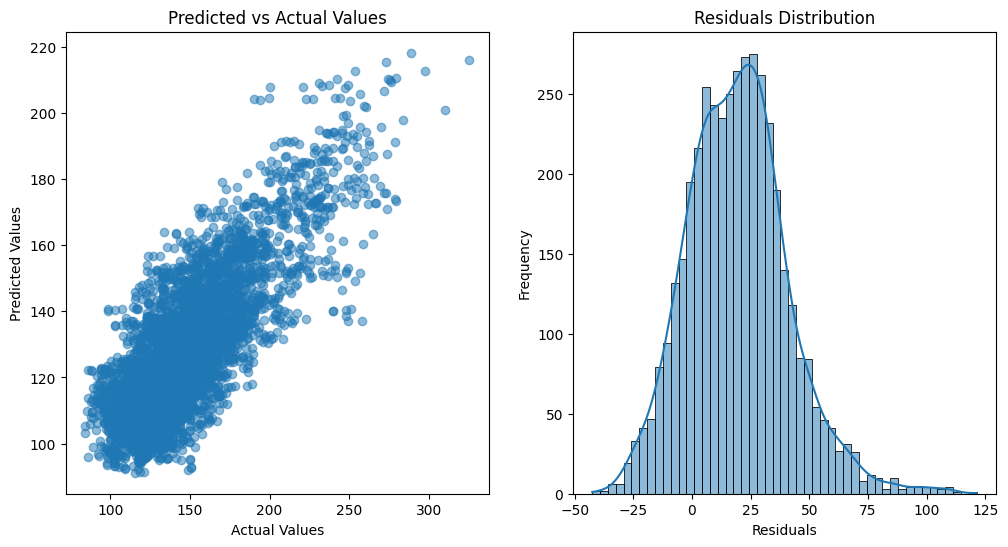

In [272]:
# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y, lr_model.predict(X), alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# Calculate residuals
residuals = y - lr_model.predict(X)

# Plot residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.savefig("../plots/residuals_LG.png")

plt.show()



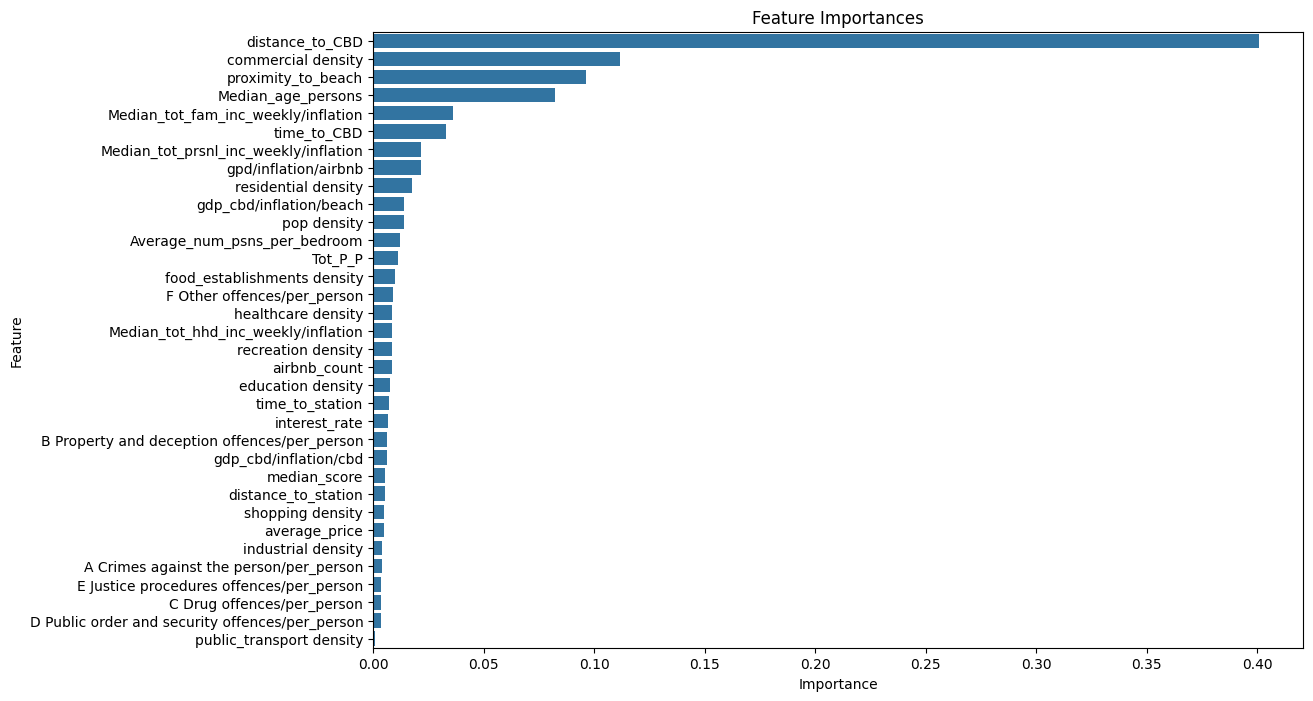

In [273]:
import seaborn as sns

import matplotlib.pyplot as plt

# Get feature importances from the RandomForest model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.savefig("../plots/feature_importance.png")


plt.show()



In [274]:
from sklearn.model_selection import train_test_split
# Define features (X) and target (y)
X = df.drop(columns=[target, 'SAL_CODE'])
y = df[target]
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Add a constant to the features (X) for the intercept term
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4269)



# drop year
X_train.drop(columns=['year'], inplace=True)
X_test.drop(columns=['year'], inplace=True)


# Initialize and train the OLS model
model = sm.OLS(y_train, X_train).fit()
    
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(model.summary())


Mean Squared Error: 226.54495011151567
R^2 Score: 0.8110721713657743
                                         OLS Regression Results                                         
Dep. Variable:     average_weekly_rent/inflation/household_size   R-squared:                       0.807
Model:                                                      OLS   Adj. R-squared:                  0.805
Method:                                           Least Squares   F-statistic:                     398.9
Date:                                          Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                                                  23:34:21   Log-Likelihood:                -13911.
No. Observations:                                          3376   AIC:                         2.789e+04
Df Residuals:                                              3340   BIC:                         2.811e+04
Df Model:                                                    35                            

In [275]:
import pandas as pd

import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Perform stepwise selection
result = stepwise_selection(X_train, y_train)

print('Selected features:')
print(result)

Add  const                          with p-value 0.0
Add  food_establishments density    with p-value 0.0


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Median_tot_prsnl_inc_weekly/inflation with p-value 1.06907e-123
Add  Median_age_persons             with p-value 3.17039e-111
Add  Median_tot_hhd_inc_weekly/inflation with p-value 4.24579e-92


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  distance_to_CBD                with p-value 3.46391e-210
Add  Median_tot_fam_inc_weekly/inflation with p-value 4.97476e-60
Add  distance_to_station            with p-value 3.9919e-34


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  interest_rate                  with p-value 1.51958e-29
Add  gdp_cbd/inflation/beach        with p-value 1.01279e-29


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  airbnb_count                   with p-value 2.55121e-33


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  gpd/inflation/airbnb           with p-value 5.21758e-25
Add  average_quarterly_count        with p-value 6.04877e-19


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  proximity_to_beach             with p-value 6.56483e-15


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  Tot_P_P                        with p-value 7.84784e-12
Add  Average_num_psns_per_bedroom   with p-value 2.04877e-16


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  pop density                    with p-value 2.21859e-10
Add  gdp_cbd/inflation/cbd          with p-value 1.4542e-06


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  E Justice procedures offences/per_person with p-value 7.59631e-06
Add  D Public order and security offences/per_person with p-value 9.23761e-07
Add  median_score                   with p-value 1.00442e-06


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  residential density            with p-value 0.000214523
Add  time_to_CBD                    with p-value 0.00197983


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  C Drug offences/per_person     with p-value 0.00578057
Add  F Other offences/per_person    with p-value 0.00476353
Add  average_price                  with p-value 0.00687302
Drop gdp_cbd/inflation/cbd          with p-value 0.0530227


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2718055390.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Selected features:
['const', 'food_establishments density', 'Median_tot_prsnl_inc_weekly/inflation', 'Median_age_persons', 'Median_tot_hhd_inc_weekly/inflation', 'distance_to_CBD', 'Median_tot_fam_inc_weekly/inflation', 'distance_to_station', 'interest_rate', 'gdp_cbd/inflation/beach', 'airbnb_count', 'gpd/inflation/airbnb', 'average_quarterly_count', 'proximity_to_beach', 'Tot_P_P', 'Average_num_psns_per_bedroom', 'pop density', 'E Justice procedures offences/per_person', 'D Public order and security offences/per_person', 'median_score', 'residential density', 'time_to_CBD', 'C Drug offences/per_person', 'F Other offences/per_person', 'average_price']


In [276]:
# Use the selected features from stepwise selection
selected_features = result

# Define the new training and testing sets based on the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initialize and train the Linear Regression model
lr_model_selected = LinearRegression()
lr_model_selected.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_selected = lr_model_selected.predict(X_test_selected)

# Evaluate the model
mse_selected = mean_squared_error(y_test, y_pred_selected)
r2_selected = r2_score(y_test, y_pred_selected)

print(f"Linear Regression with Selected Features Mean Squared Error: {mse_selected}")
print(f"Linear Regression with Selected Features R^2 Score: {r2_selected}")

Linear Regression with Selected Features Mean Squared Error: 226.87435284253846
Linear Regression with Selected Features R^2 Score: 0.8107974649876905


In [277]:
selected_features

['const',
 'food_establishments density',
 'Median_tot_prsnl_inc_weekly/inflation',
 'Median_age_persons',
 'Median_tot_hhd_inc_weekly/inflation',
 'distance_to_CBD',
 'Median_tot_fam_inc_weekly/inflation',
 'distance_to_station',
 'interest_rate',
 'gdp_cbd/inflation/beach',
 'airbnb_count',
 'gpd/inflation/airbnb',
 'average_quarterly_count',
 'proximity_to_beach',
 'Tot_P_P',
 'Average_num_psns_per_bedroom',
 'pop density',
 'E Justice procedures offences/per_person',
 'D Public order and security offences/per_person',
 'median_score',
 'residential density',
 'time_to_CBD',
 'C Drug offences/per_person',
 'F Other offences/per_person',
 'average_price']

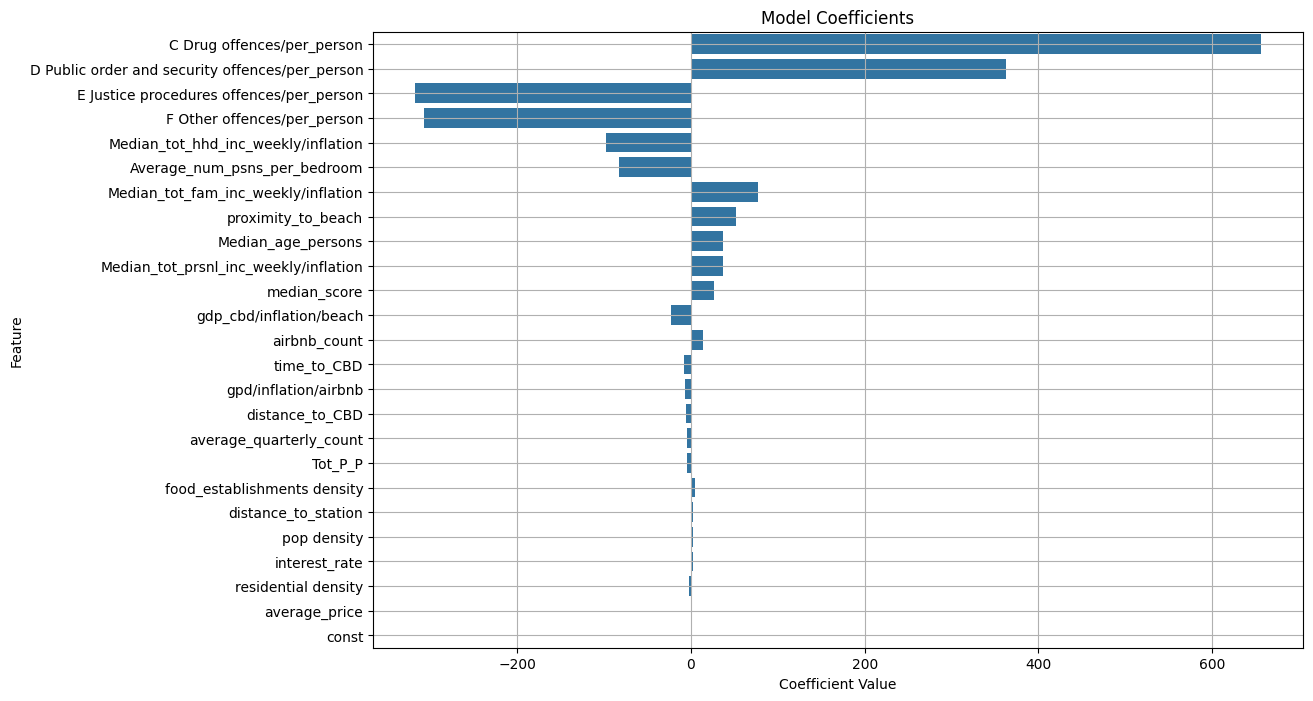

In [278]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the coefficients from the model
coefficients = lr_model_selected.coef_
coefficients = pd.Series(coefficients, index=X_train_selected.columns)

# Sort the coefficients by their absolute values
coefficients = coefficients.sort_values(key=abs, ascending=False)

# Remove the top 5 coefficients
coefficients = coefficients

# Plot the remaining coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x=coefficients.values, y=coefficients.index)
plt.title('Model Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True)


plt.savefig("../plots/model_coefficients.png")

plt.show()


In [279]:
# Initialize and train the Random Forest model
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest Mean Squared Error: 54.735364955987045
Random Forest R^2 Score: 0.954353281123476


In [280]:
X_train.columns


X_train.drop(columns=['average_quarterly_count'], inplace=True)
X_test.drop(columns=['average_quarterly_count'], inplace=True)

In [281]:
import geopandas as gpd
import pandas as pd

In [282]:
from math import asin
from numpy import cos, sin, sqrt, radians


melbourne_cbd_coords = (-37.8136, 144.9631)  # Latitude and Longitude of Melbourne CBD

# Function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of earth in kilometers
    return c * r


def generate_plot(ax, df, col, sal_code="SAL_CODE", name="", vmin=None, vmax=None):
    sal_code = gpd.read_file("../data/landing/SAL_data/SAL_2021_AUST_GDA2020.shp")

    # Drop non-integer SAL_CODE21 values
    sal_code = sal_code[sal_code['SAL_CODE21'].apply(lambda x: str(x).isdigit())]
    sal_code["SAL_CODE21"] = sal_code["SAL_CODE21"].astype(int)

    merged_df = sal_code.merge(df, left_on='SAL_CODE21', right_on='SAL_CODE', how='inner')

    # Apply the function to calculate distance to Melbourne CBD
    merged_df['distance_to_CBD'] = merged_df.apply(lambda row: haversine(row['geometry'].centroid.y, row['geometry'].centroid.x, melbourne_cbd_coords[0], melbourne_cbd_coords[1]), axis=1)

    # Filter out suburbs too far outside Melbourne (e.g., more than 50 km)
    merged_df = merged_df[merged_df['distance_to_CBD'] <= 100]
    
    # Plot the data
    ax.set_title(name)
    merged_df.plot(column=col, ax=ax, legend=True, cmap='coolwarm', vmin=vmin, vmax=vmax, )

    

In [283]:
df['year']

0       2016
3679    2016
2418    2016
5213    2016
884     2016
        ... 
2543    2024
996     2024
5078    2024
5091    2024
580     2024
Name: year, Length: 4221, dtype: int64

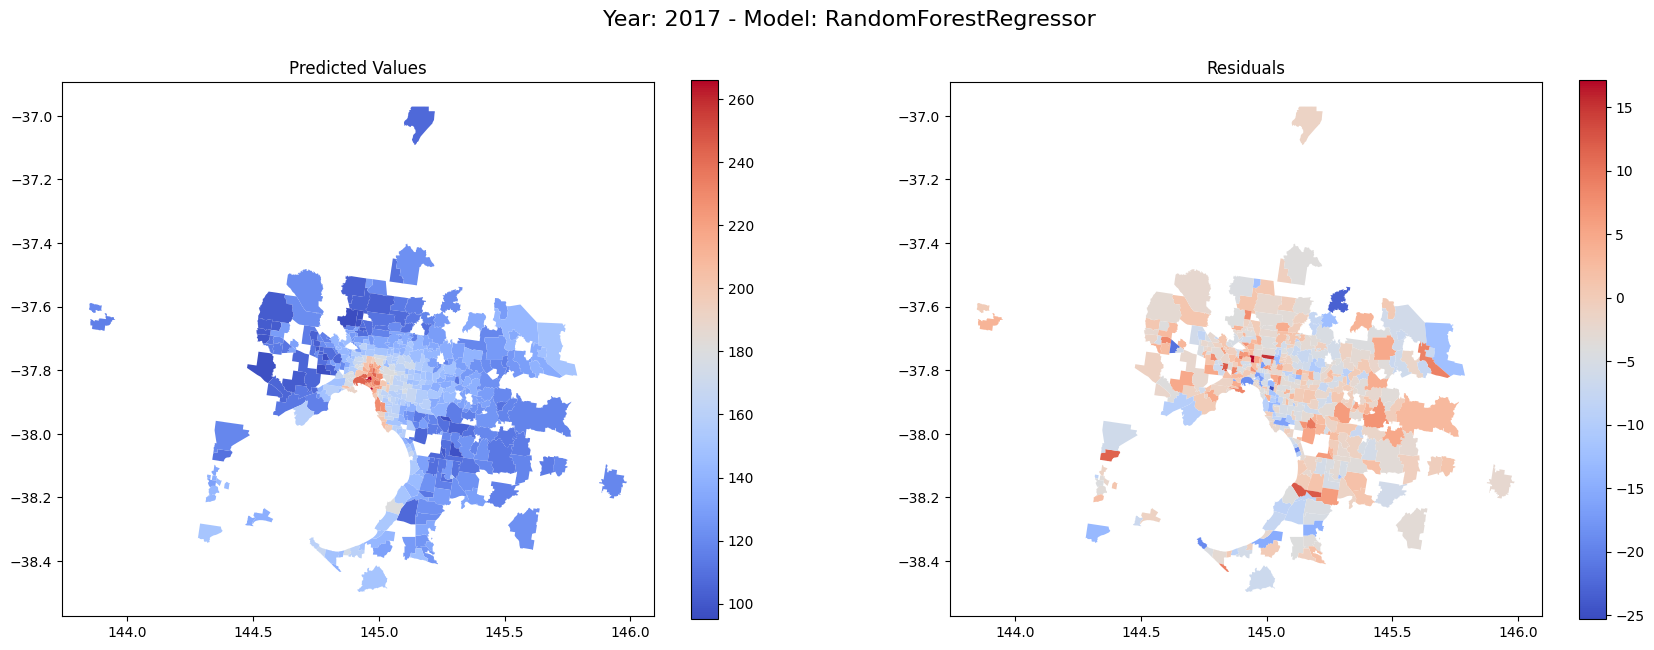

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2242591312.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)


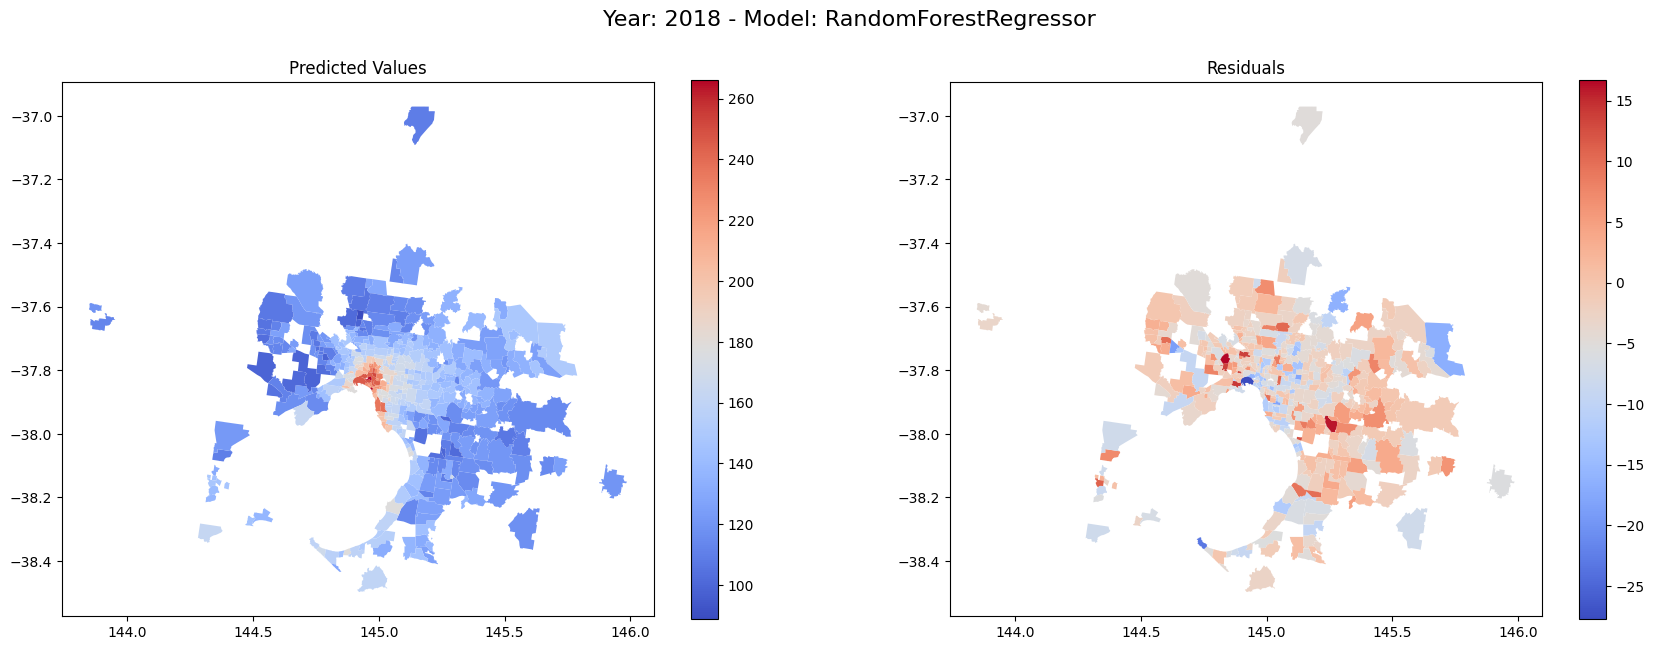

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2242591312.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)


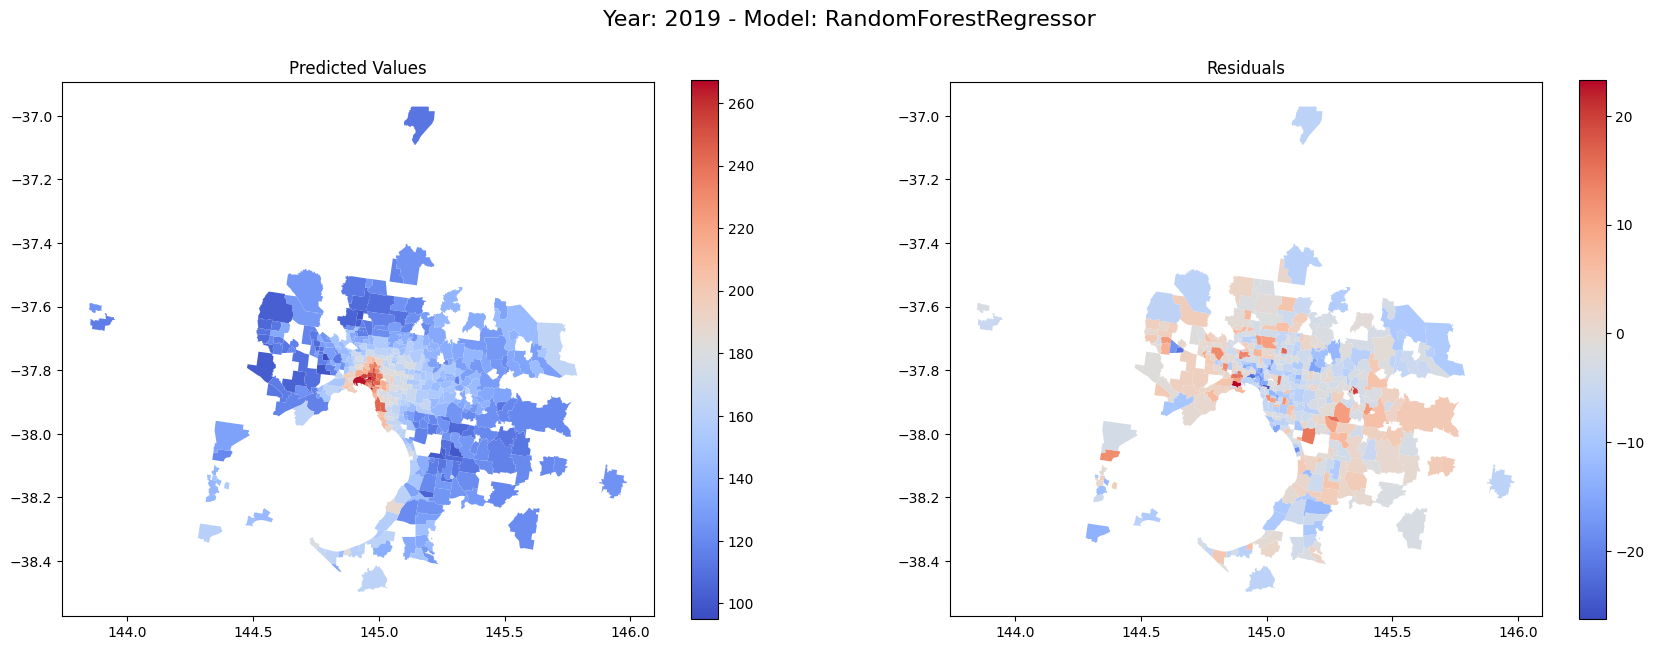

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2242591312.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)


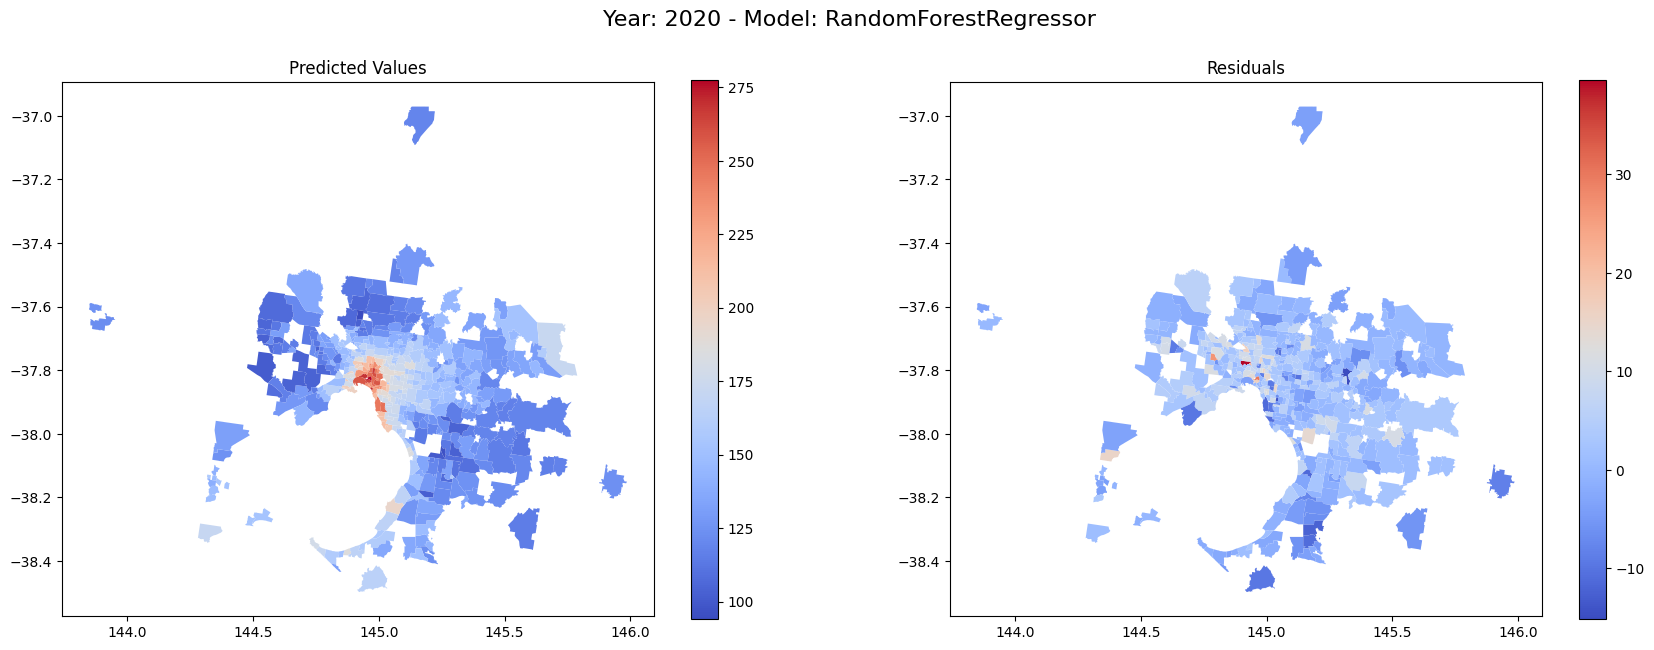

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2242591312.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)


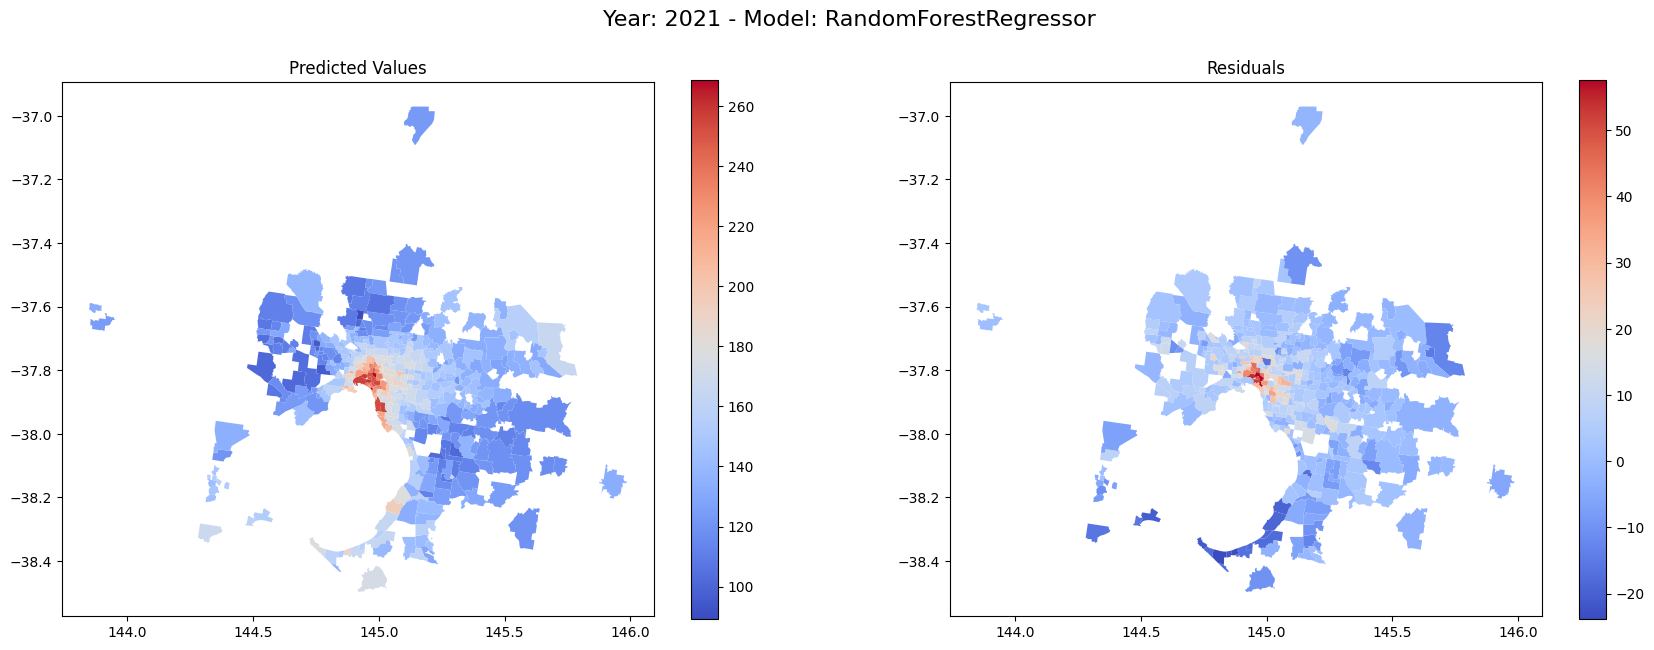

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2242591312.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)


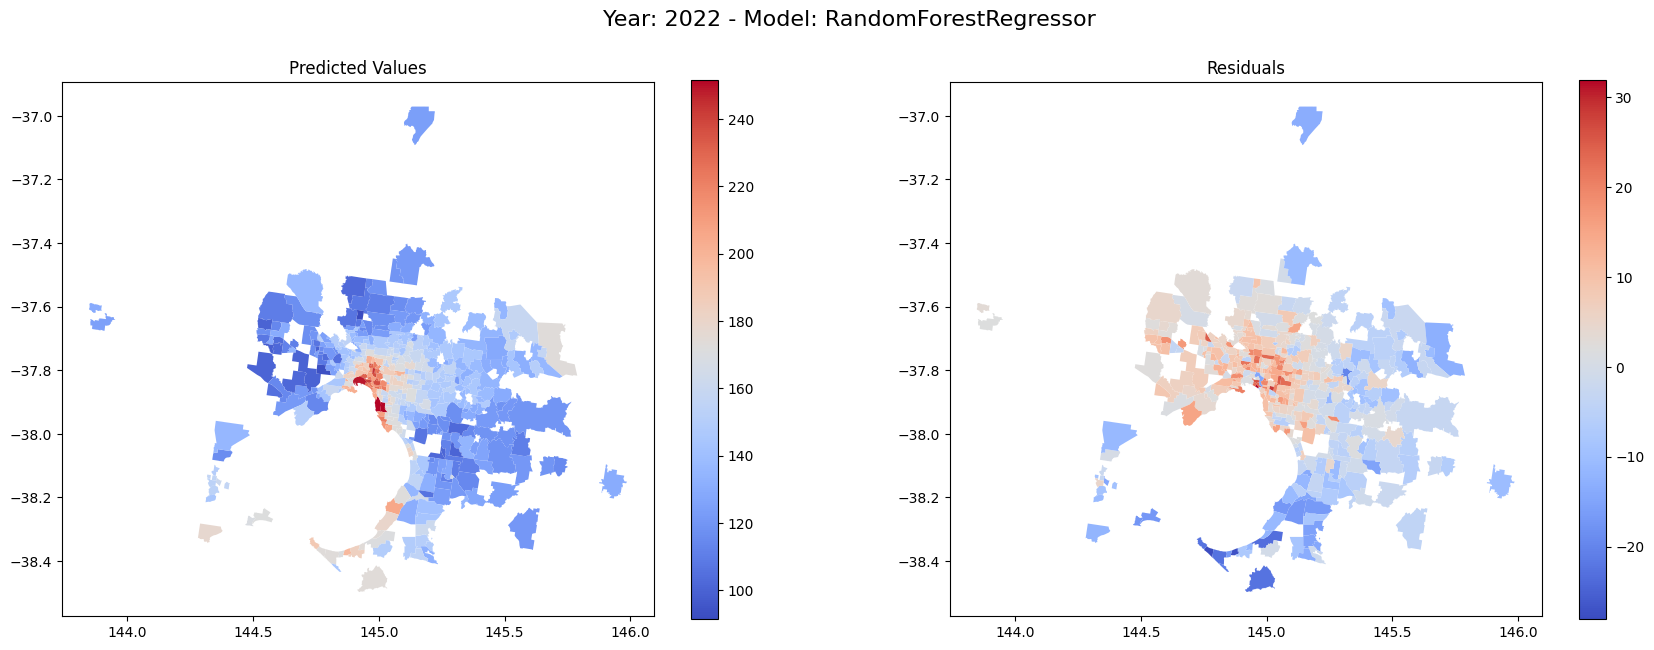

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2242591312.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)


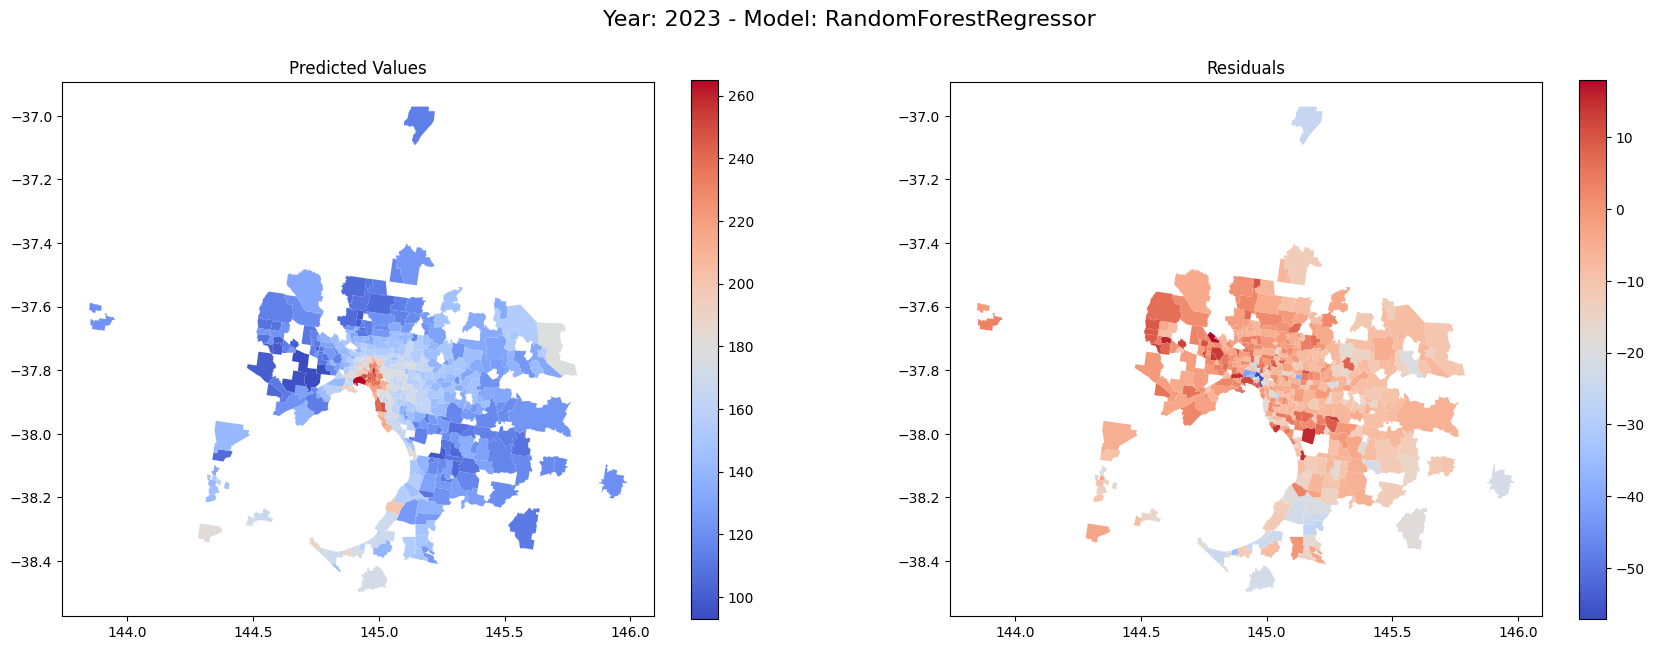

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2242591312.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)


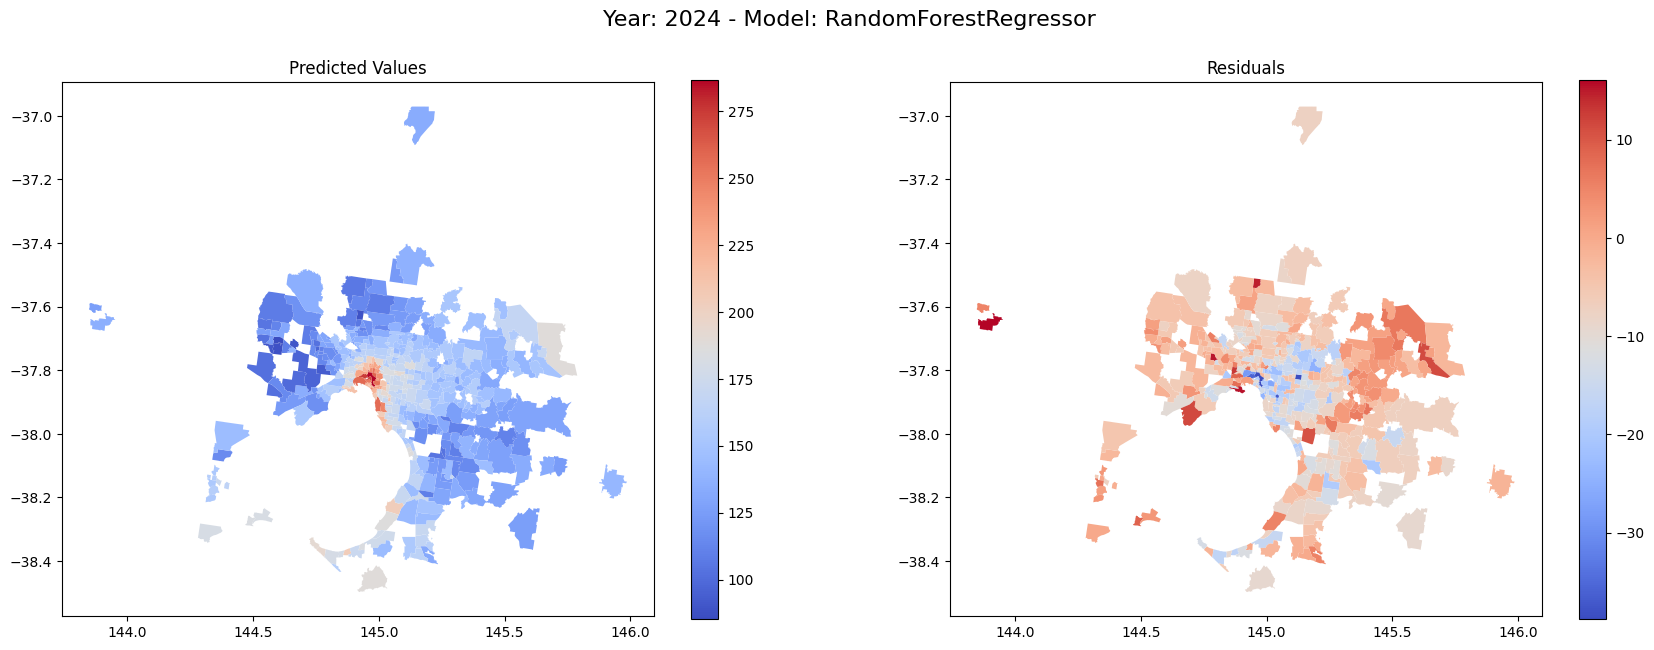

                                        train_years test_year         mse  \
0                                            [2016]    [2017]   35.461962   
1                                      [2016, 2017]    [2018]   38.708153   
2                                [2016, 2017, 2018]    [2019]   45.277704   
3                          [2016, 2017, 2018, 2019]    [2020]   38.259844   
4                    [2016, 2017, 2018, 2019, 2020]    [2021]  153.798125   
5              [2016, 2017, 2018, 2019, 2020, 2021]    [2022]  101.191369   
6        [2016, 2017, 2018, 2019, 2020, 2021, 2022]    [2023]  132.810465   
7  [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]    [2024]  105.500509   

         r2  
0  0.968386  
1  0.967878  
2  0.964875  
3  0.967996  
4  0.820816  
5  0.887860  
6  0.887559  
7  0.921982  


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/2242591312.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)


In [284]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor  # Import XGBRegressor

# Initialize the TimeSeriesSplit with the number of splits equal to the number of years minus one
years = sorted(df['year'].unique())
n_splits = len(years) - 1
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=['train_years', 'test_year', 'mse', 'r2'])

# Iterate through the splits
for train_index, test_index in tscv.split(df):
    train_years = df.iloc[train_index]['year'].unique()
    test_year = df.iloc[test_index]['year'].unique()
    
    # Split the data into training and testing sets
    X_train, X_test = df.iloc[train_index].drop(columns=[target, 'year']), df.iloc[test_index].drop(columns=[target, 'year'])
    y_train, y_test = df.iloc[train_index][target], df.iloc[test_index][target]

    
    # Initialize and train the model
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    SAL_test = df.iloc[test_index]['SAL_CODE']
    
    df_graphing = pd.DataFrame({
        'SAL_CODE': SAL_test,
        'pred': y_pred,
        'actual' : y_test,
        'residuals': y_pred - y_test
    })
    

    fig, axes = plt.subplots(1, 2, figsize=(21, 7))

    # Add a big title for the year
    fig.suptitle(f'Year: {test_year[0]} - Model: RandomForestRegressor', fontsize=16)

    generate_plot(axes[0], df_graphing, "pred")
    axes[0].set_title('Predicted Values')

    generate_plot(axes[1], df_graphing, 'residuals')
    axes[1].set_title('Residuals')
    # Add text annotation for the year and the type of model
    plt.savefig(f"../plots/RF_residuals_{test_year[0]}.png")
    plt.show()




    # Store the results
    results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2}, ignore_index=True)

# Display the results
print(results)

SAL_CODE        pred      actual  residuals
2803     21319  144.859299  149.060433  -4.201135
216      20974  161.680618  158.435728   3.244891
4142     20062  134.785706  146.105262 -11.319556
2075     21246  169.292633  182.107449 -12.814816
1178     21966  221.205460  229.438406  -8.232946
...        ...         ...         ...        ...
2543     20362  213.486694  218.196082  -4.709388
996      20495  242.546463  253.436808 -10.890345
5078     20581  123.207062  127.656287  -4.449225
5091     20582  114.325554  119.096244  -4.770690
580      20937  169.917725  187.378091 -17.460366

[469 rows x 4 columns]

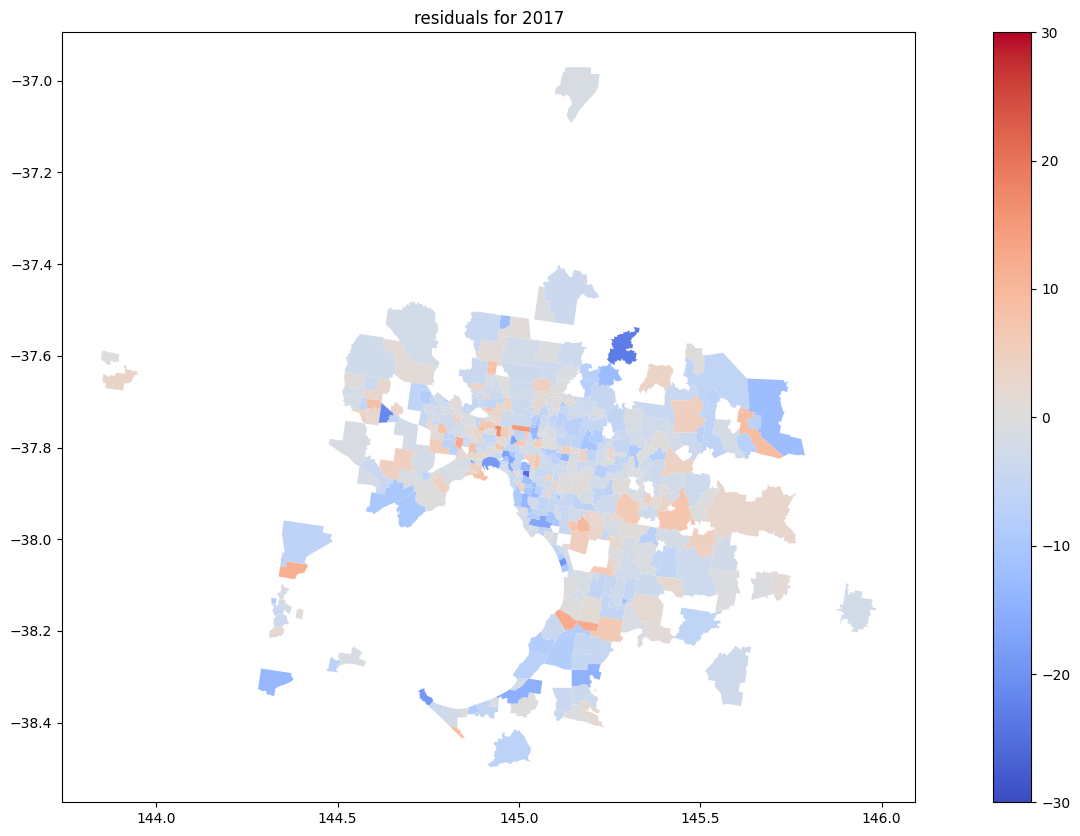

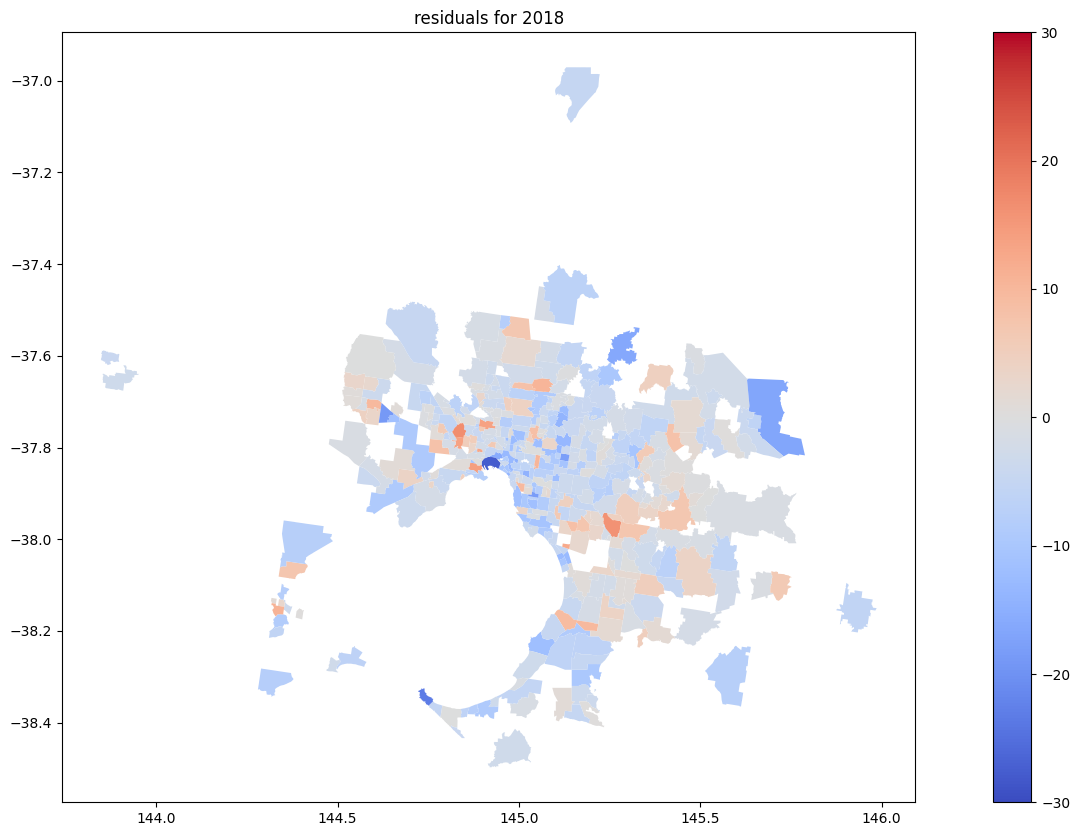

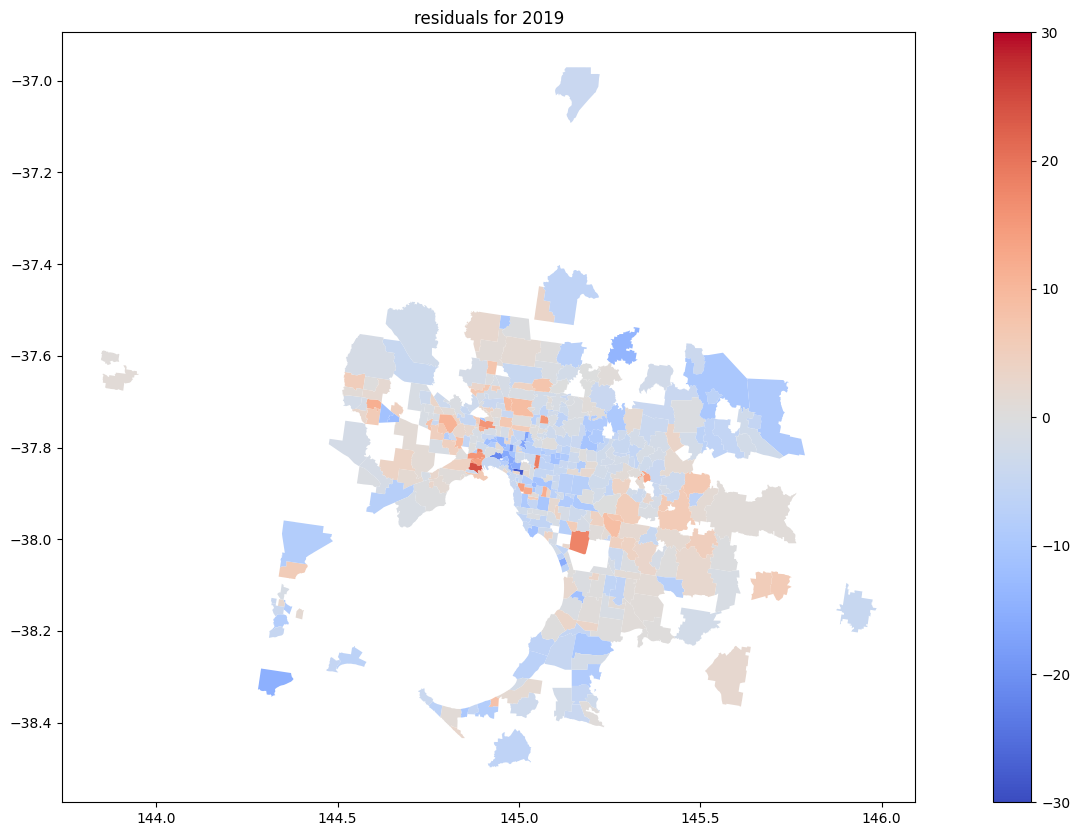

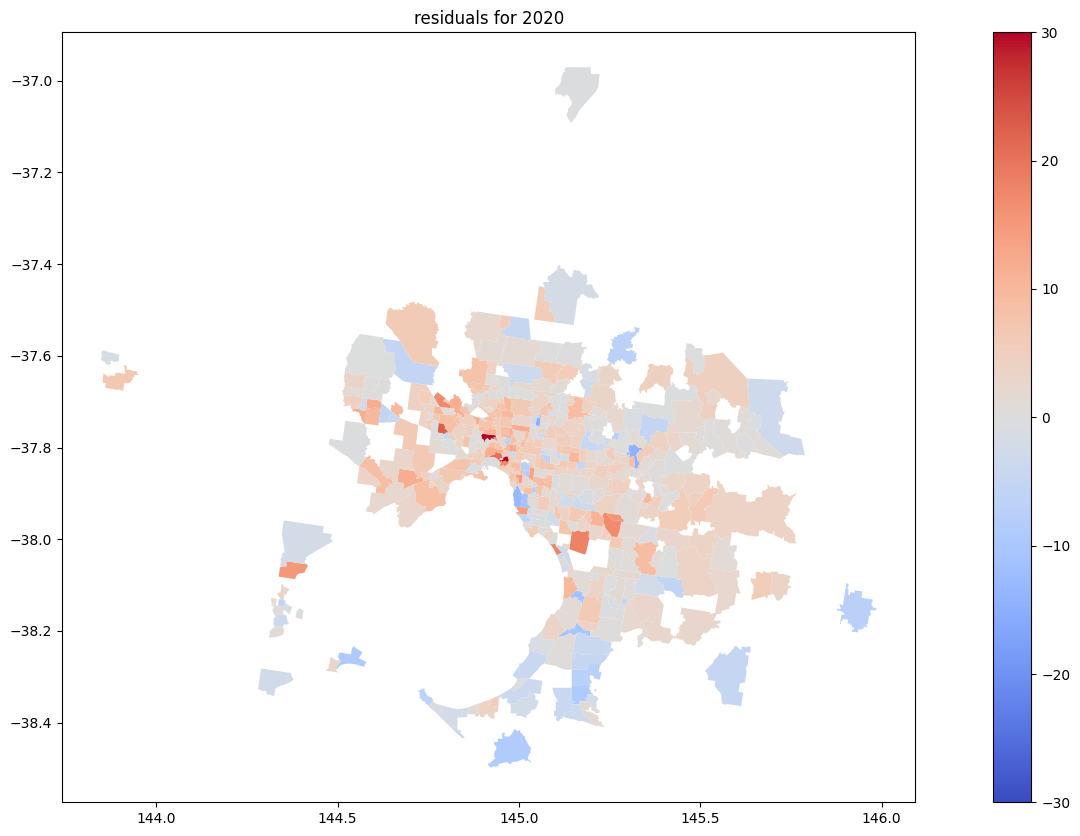

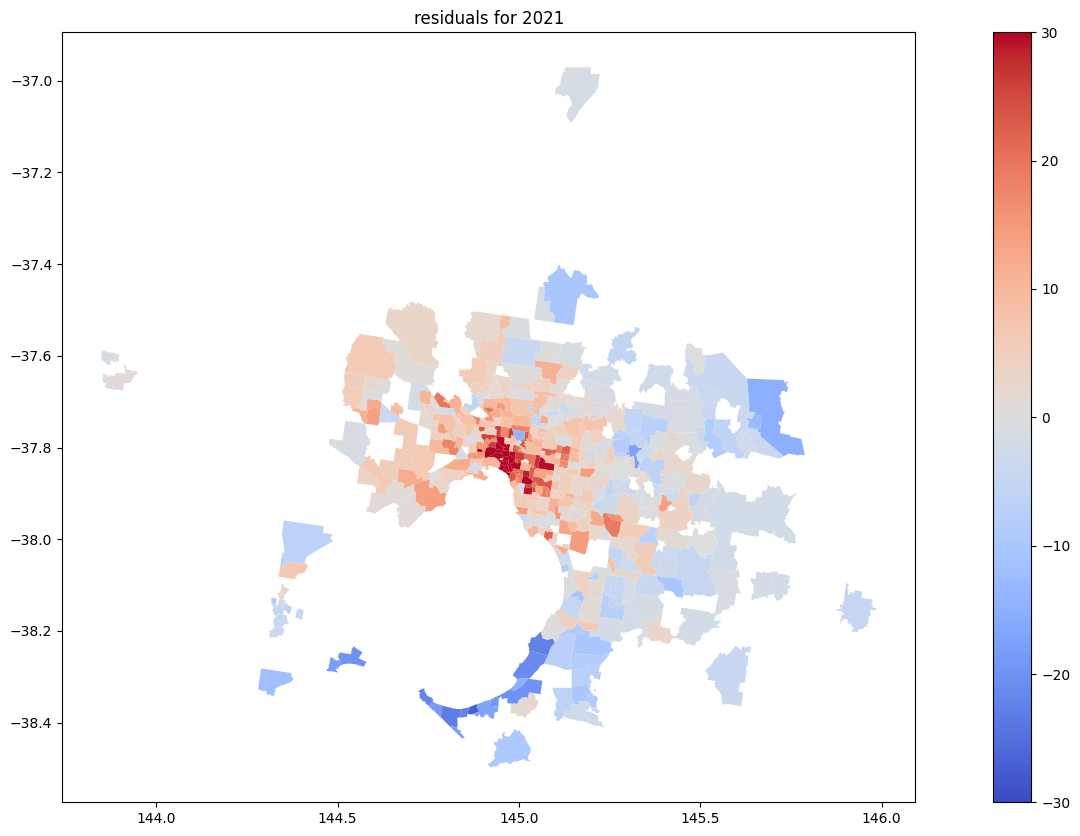

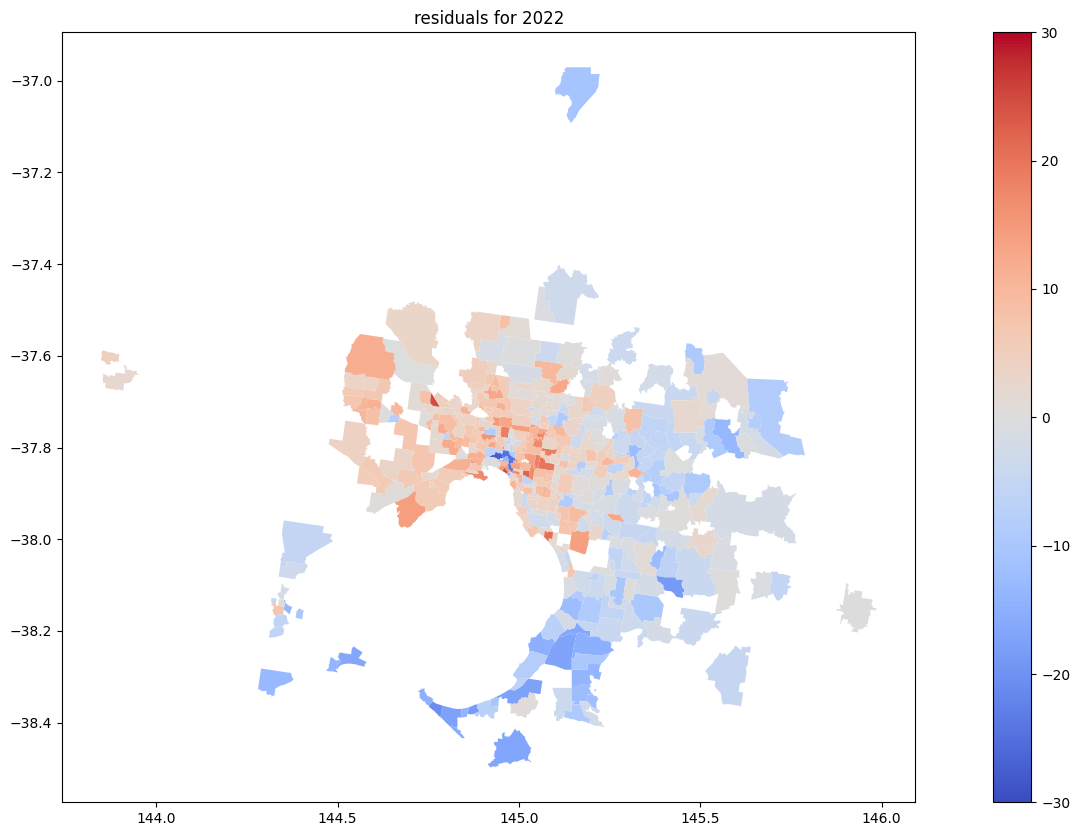

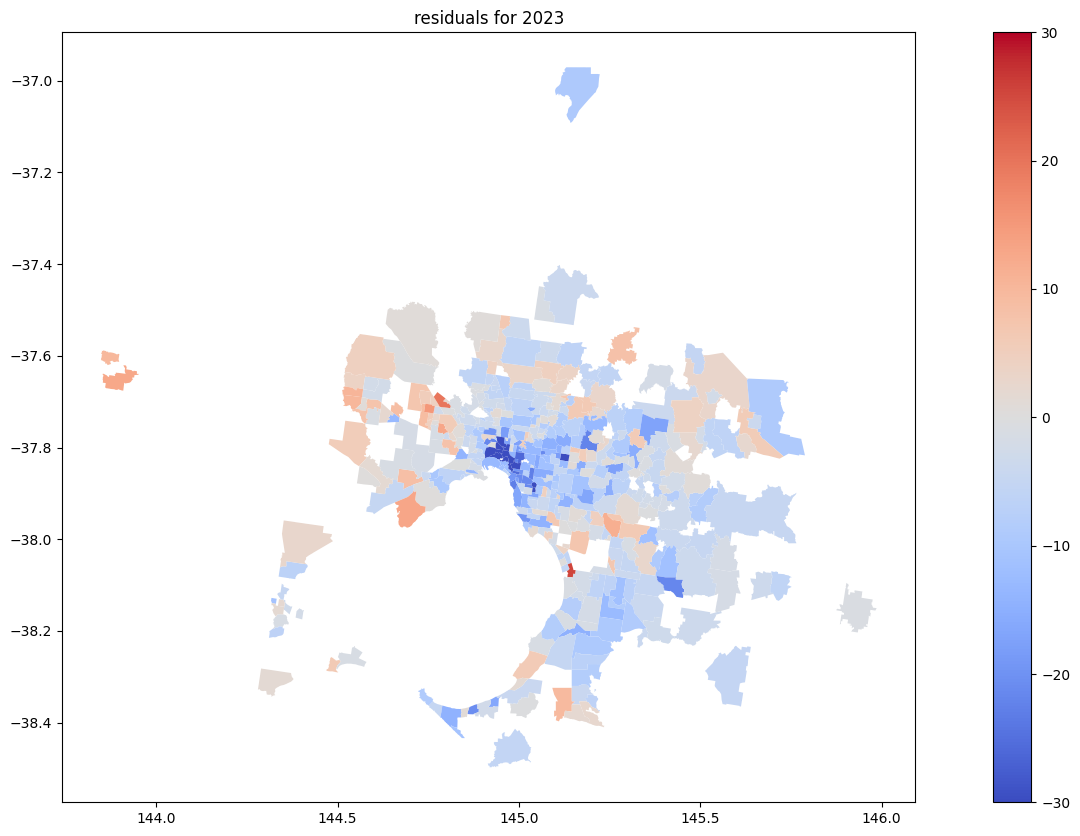

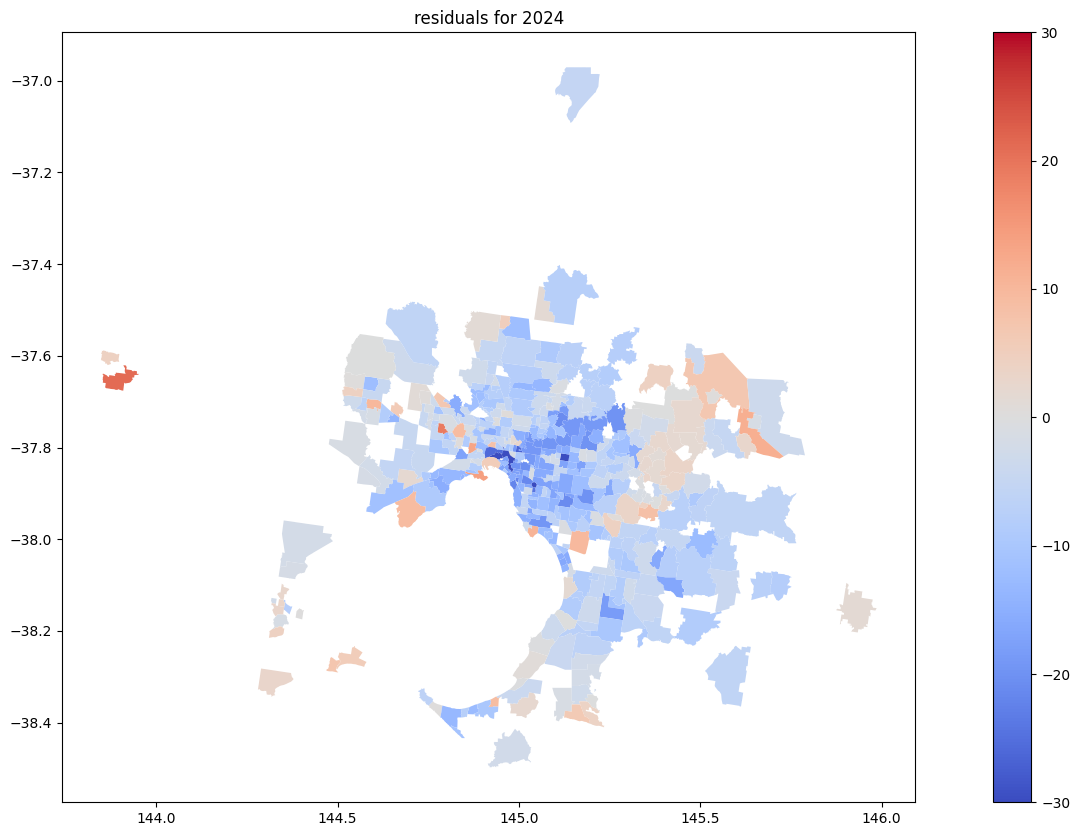

In [285]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor  # Import XGBRegressor

# Initialize the TimeSeriesSplit with the number of splits equal to the number of years minus one

n_splits = len(years) - 1
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=['train_years', 'test_year', 'mse', 'r2'])

dfs = []

# Iterate through the splits
for train_index, test_index in tscv.split(df):
    train_years = df.iloc[train_index]['year'].unique()
    test_year = df.iloc[test_index]['year'].unique()
    
    # Split the data into training and testing sets
    X_train, X_test = df.iloc[train_index].drop(columns=[target]), df.iloc[test_index].drop(columns=[target])
    y_train, y_test = df.iloc[train_index][target], df.iloc[test_index][target]

    
    # Initialize and train the model
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    SAL_test = df.iloc[test_index]['SAL_CODE']
    
    df_graphing = pd.DataFrame({
        'SAL_CODE': SAL_test,
        'pred': y_pred,
        'actual' : y_test,
        'residuals': y_pred - y_test
    })

    dfs.append(df_graphing)

    fig, axes = plt.subplots(figsize=(20, 15))

    generate_plot(axes, df_graphing, 'residuals', name=f"residuals for {test_year[0]}", vmax=30, vmin=-30)
    plt.savefig(f"../plots/XGBOOSTresiduals_{test_year[0]}.png")


dfs[-1]

/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/203489540.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2, 'mean_actual': mean_actual, 'mean_predicted': mean_predicted}, ignore_index=True)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/203489540.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2, 'mean_actual': mean_actual, 'mean_predicted': mean_predicted}, ignore_index=True)
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/203489540.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

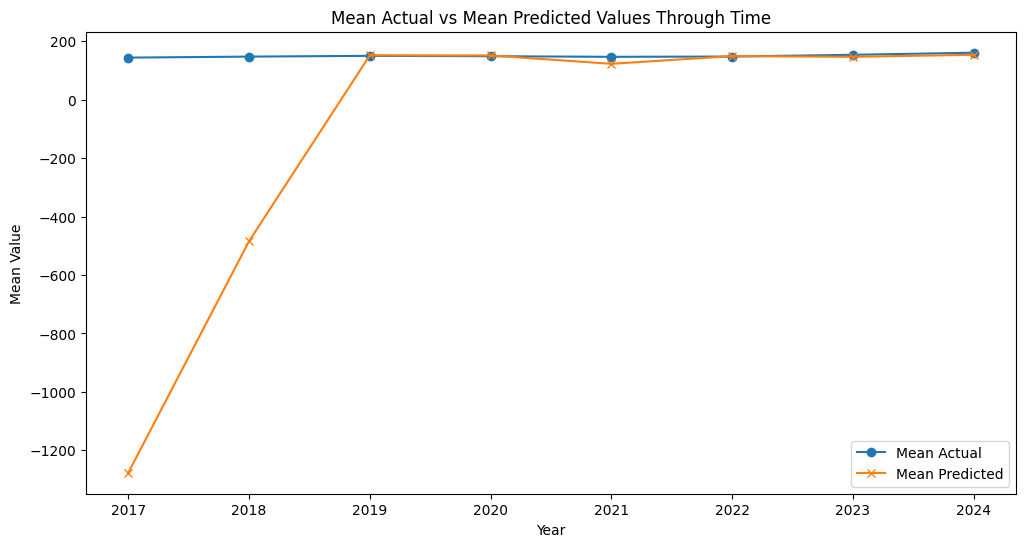

                                        train_years test_year           mse  \
0                                            [2016]      2017  2.017016e+06   
1                                      [2016, 2017]      2018  3.986628e+05   
2                                [2016, 2017, 2018]      2019  1.742532e+02   
3                          [2016, 2017, 2018, 2019]      2020  1.825328e+02   
4                    [2016, 2017, 2018, 2019, 2020]      2021  8.755986e+02   
5              [2016, 2017, 2018, 2019, 2020, 2021]      2022  3.432103e+02   
6        [2016, 2017, 2018, 2019, 2020, 2021, 2022]      2023  3.273434e+02   
7  [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]      2024  3.311369e+02   

            r2  mean_actual  mean_predicted  
0 -1797.128417   143.653082    -1276.511564  
1  -329.831115   147.056260     -484.217089  
2     0.864821   149.720245      151.717318  
3     0.847314   148.427841      151.039487  
4    -0.020122   146.350302      122.445628  
5     0.6196

In [286]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# Initialize the TimeSeriesSplit with the number of splits equal to the number of years minus one
years = sorted(df['year'].unique())
n_splits = len(years) - 1
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=['train_years', 'test_year', 'mse', 'r2'])

# Iterate through the splits
for train_index, test_index in tscv.split(df):
    
    train_years = df.iloc[train_index]['year'].unique()
    test_year = df.iloc[test_index]['year'].unique()[0]
    
    # Split the data into training and testing sets
    X_train, X_test = df.iloc[train_index].drop(columns=[target, 'year','SAL_CODE']), df.iloc[test_index].drop(columns=[target, 'year','SAL_CODE'])
    y_train, y_test = df.iloc[train_index][target], df.iloc[test_index][target]
    
    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate mean actual and mean predicted values
    mean_actual = y_test.mean()
    mean_predicted = y_pred.mean()
    
    # Append the results to the DataFrame
    results = results.append({'train_years': train_years, 'test_year': test_year, 'mse': mse, 'r2': r2, 'mean_actual': mean_actual, 'mean_predicted': mean_predicted}, ignore_index=True)

# Plot mean actual and mean predicted values through time
plt.figure(figsize=(12, 6)) 
plt.plot(results['test_year'], results['mean_actual'], label='Mean Actual', marker='o')
plt.plot(results['test_year'], results['mean_predicted'], label='Mean Predicted', marker='x')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.title('Mean Actual vs Mean Predicted Values Through Time')
plt.legend()
plt.show()

# Display the results
print(results)


In [287]:
# Get counts per year
year_counts = df['year'].value_counts().sort_index()

# Print the counts
print(year_counts)

2016    469
2017    469
2018    469
2019    469
2020    469
2021    469
2022    469
2023    469
2024    469
Name: year, dtype: int64


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/302009939.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/302009939.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/302009939.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_61679/302009939.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/var/folders/vs/mmhmvz21

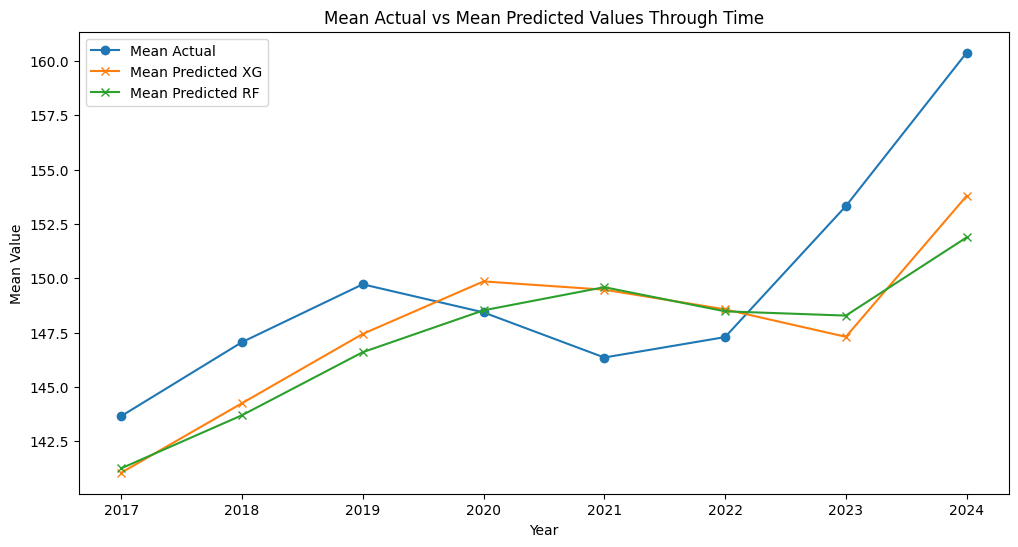

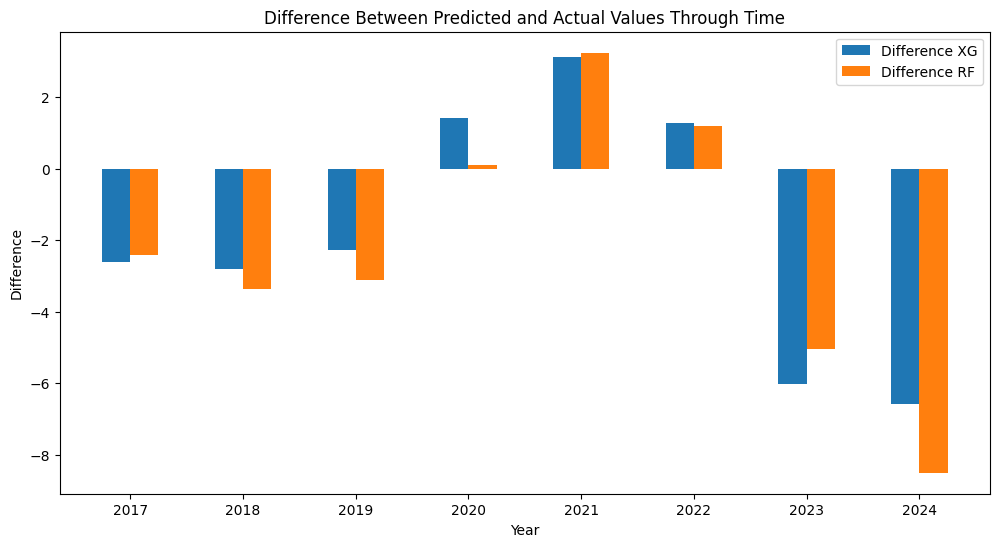

                                        train_years test_year      mse_XG  \
0                                            [2016]      2017   39.735413   
1                                      [2016, 2017]      2018   45.068627   
2                                [2016, 2017, 2018]      2019   42.803328   
3                          [2016, 2017, 2018, 2019]      2020   36.330456   
4                    [2016, 2017, 2018, 2019, 2020]      2021  156.699855   
5              [2016, 2017, 2018, 2019, 2020, 2021]      2022  109.931314   
6        [2016, 2017, 2018, 2019, 2020, 2021, 2022]      2023  122.117698   
7  [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]      2024  107.112798   

      r2_XG        mse_LG        r2_LG      mse_RF     r2_RF  mean_actual  \
0  0.964577  2.017016e+06 -1797.128417   69.463392  0.938075   143.653082   
1  0.962600  3.986628e+05  -329.831115   51.732001  0.957070   147.056260   
2  0.966795  1.742532e+02     0.864821   48.975037  0.962007   149.720245  

In [288]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# Initialize the TimeSeriesSplit with the number of splits equal to the number of years minus one
years = sorted(df['year'].unique())
n_splits = len(years) - 1
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=['train_years', 'test_year', 'mse_XG', 'r2_XG', 'mse_LG', 'r2_LG', 'mse_RF', 'r2_RF'])

# Iterate through the splits
for train_index, test_index in tscv.split(df):
    
    train_years = df.iloc[train_index]['year'].unique()
    test_year = df.iloc[test_index]['year'].unique()[0]
    
    # Split the data into training and testing sets
    X_train, X_test = df.iloc[train_index].drop(columns=[target, 'year','SAL_CODE']), df.iloc[test_index].drop(columns=[target, 'year','SAL_CODE'])
    y_train, y_test = df.iloc[train_index][target], df.iloc[test_index][target]
    
    # Initialize and train the models
    modelXGBR = xgb.XGBRegressor(objective='reg:squarederror')
    modelXGBR.fit(X_train, y_train)

    modelLG = LinearRegression()
    modelLG.fit(X_train, y_train)

    modelRF = RandomForestRegressor(random_state=42)
    modelRF.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_XG = modelXGBR.predict(X_test)
    y_pred_LG = modelLG.predict(X_test)
    y_pred_RF = modelRF.predict(X_test)
    
    # Evaluate the models
    mse_XG = mean_squared_error(y_test, y_pred_XG)
    r2_XG = r2_score(y_test, y_pred_XG)
    
    mse_LG = mean_squared_error(y_test, y_pred_LG)
    r2_LG = r2_score(y_test, y_pred_LG)
    
    mse_RF = mean_squared_error(y_test, y_pred_RF)
    r2_RF = r2_score(y_test, y_pred_RF)
    
    # Calculate mean actual and mean predicted values
    mean_actual = y_test.mean()

    mean_predicted_XG = y_pred_XG.mean()
    mean_predicted_LG = y_pred_LG.mean()
    mean_predicted_RF = y_pred_RF.mean()
    
    # Append the results to the DataFrame
    results = results.append({
        'train_years': train_years, 
        'test_year': test_year, 
        'mse_XG': mse_XG, 
        'r2_XG': r2_XG, 
        'mse_LG': mse_LG, 
        'r2_LG': r2_LG, 
        'mse_RF': mse_RF, 
        'r2_RF': r2_RF, 
        'mean_actual': mean_actual, 
        'mean_predicted_XG': mean_predicted_XG, 
        'mean_predicted_LG': mean_predicted_LG, 
        'mean_predicted_RF': mean_predicted_RF
    }, ignore_index=True)

# Plot mean actual and mean predicted values through time
plt.figure(figsize=(12, 6)) 
plt.plot(results['test_year'], results['mean_actual'], label='Mean Actual', marker='o')
plt.plot(results['test_year'], results['mean_predicted_XG'], label='Mean Predicted XG', marker='x')
#plt.plot(results['test_year'], results['mean_predicted_LG'], label='Mean Predicted LG', marker='x')
plt.plot(results['test_year'], results['mean_predicted_RF'], label='Mean Predicted RF', marker='x')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.title('Mean Actual vs Mean Predicted Values Through Time')
plt.legend()
plt.savefig("../plots/mean_actual_vs_predicted_through_time.png")
plt.show()


# Plot the difference between predicted and actual values as a bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.25
years = results['test_year']
index = np.arange(len(years))

plt.bar(index, results['mean_predicted_XG'] - results['mean_actual'], bar_width, label='Difference XG')
#plt.bar(index + bar_width, results['mean_predicted_LG'] - results['mean_actual'], bar_width, label='Difference LG')
plt.bar(index + bar_width, results['mean_predicted_RF'] - results['mean_actual'], bar_width, label='Difference RF')

plt.xlabel('Year')
plt.ylabel('Difference')
plt.title('Difference Between Predicted and Actual Values Through Time')
plt.xticks(index + bar_width / 2, years)
plt.legend()
plt.savefig("../plots/difference_predicted_actual_through_time.png")
plt.show()



# Display the results
print(results)


In [289]:
# Drop the 'year' column from the dataset
X_no_year = df.drop(columns=[target, 'year','SAL_CODE'])


# Make predictions on the entire dataset
y_pred_xgb_full = model.predict(X_no_year)

# Calculate residuals for the entire dataset
residuals_xgb = y - y_pred_xgb_full

# Display the residuals
residuals_xgb

0       -5.372448
3679    -4.336672
2418     6.628183
5213     4.662561
884      0.063182
          ...    
2543     2.475870
996     30.292386
5078     9.559552
5091    10.937767
580     27.207501
Name: average_weekly_rent/inflation/household_size, Length: 4221, dtype: float64

In [290]:
# find SAL code of 10 highest residuals
residuals_df = pd.DataFrame({'SAL_CODE': df['SAL_CODE'], 'year': data_train['year'], 'residuals': residuals,'xg_residuals':residuals_xgb, 'average_weekly_rent': df['average_weekly_rent/inflation/household_size']})

residuals_df



SAL_CODE  year  residuals  xg_residuals  average_weekly_rent
0      20023.0  2016 -16.364556     -5.372448           101.439296
1      20023.0  2017 -15.738390     -5.102863           101.073282
2      20023.0  2018 -15.598570     -5.140382           102.902997
3      20023.0  2019 -10.239386     -0.357713           108.332365
4      20023.0  2020  -2.952107      4.676226           111.708069
...        ...   ...        ...           ...                  ...
6092   22720.0  2024   9.221151      0.275360           134.154390
6093       NaN  2025        NaN           NaN                  NaN
6094       NaN  2026        NaN           NaN                  NaN
6095       NaN  2027        NaN           NaN                  NaN
6096       NaN  2028        NaN           NaN                  NaN

[6097 rows x 5 columns]

In [291]:
import geopandas as gpd

In [292]:
# import SAL
sal_code = gpd.read_file("../data/landing/SAL_data/SAL_2021_AUST_GDA2020.shp")

# Drop non-integer SAL_CODE21 values
sal_code = sal_code[sal_code['SAL_CODE21'].apply(lambda x: str(x).isdigit())]
sal_code["SAL_CODE21"] = sal_code["SAL_CODE21"].astype(int)

In [293]:
# residuals_df 
residuals_df = residuals_df.merge(sal_code, right_on='SAL_CODE21', left_on='SAL_CODE')

In [294]:
from math import radians, cos, sin, asin, sqrt

# for better visualisaiton, remove suburbs too far outside melbourne
# Compute distance to Melbourne CBD
melbourne_cbd_coords = (-37.8136, 144.9631)  # Latitude and Longitude of Melbourne CBD

# Function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of earth in kilometers
    return c * r

# Apply the function to calculate distance to Melbourne CBD
residuals_df['distance_to_CBD'] = residuals_df.apply(lambda row: haversine(row['geometry'].centroid.y, row['geometry'].centroid.x, melbourne_cbd_coords[0], melbourne_cbd_coords[1]), axis=1)

# Filter out suburbs too far outside Melbourne (e.g., more than 50 km)
residuals_df = residuals_df[residuals_df['distance_to_CBD'] <= 100]

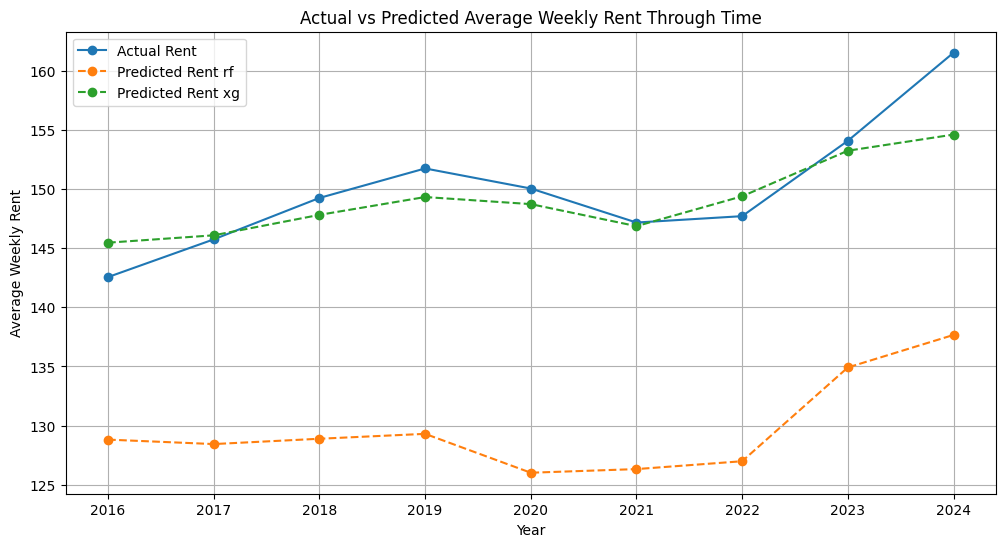

1200

In [295]:
# Calculate the predicted values by subtracting residuals from actual values
residuals_df['predicted_rent'] = residuals_df['average_weekly_rent'] - residuals_df['residuals']
residuals_df['predicted_rent_xg'] = residuals_df['average_weekly_rent'] - residuals_df['xg_residuals']

# Group by year and calculate the mean for actual and predicted rents
mean_rents = residuals_df.groupby('year')[['average_weekly_rent', 'predicted_rent',"predicted_rent_xg"]].mean().reset_index()

# Plot the actual vs predicted rents through time
plt.figure(figsize=(12, 6))
plt.plot(mean_rents['year'], mean_rents['average_weekly_rent'], marker='o', label='Actual Rent')
plt.plot(mean_rents['year'], mean_rents['predicted_rent'], marker='o', label='Predicted Rent rf', linestyle='--')
plt.plot(mean_rents['year'], mean_rents['predicted_rent_xg'], marker='o', label='Predicted Rent xg', linestyle='--')
plt.title('Actual vs Predicted Average Weekly Rent Through Time')
plt.xlabel('Year')
plt.ylabel('Average Weekly Rent')
plt.legend()
plt.grid(True)
plt.show()

150 * 8

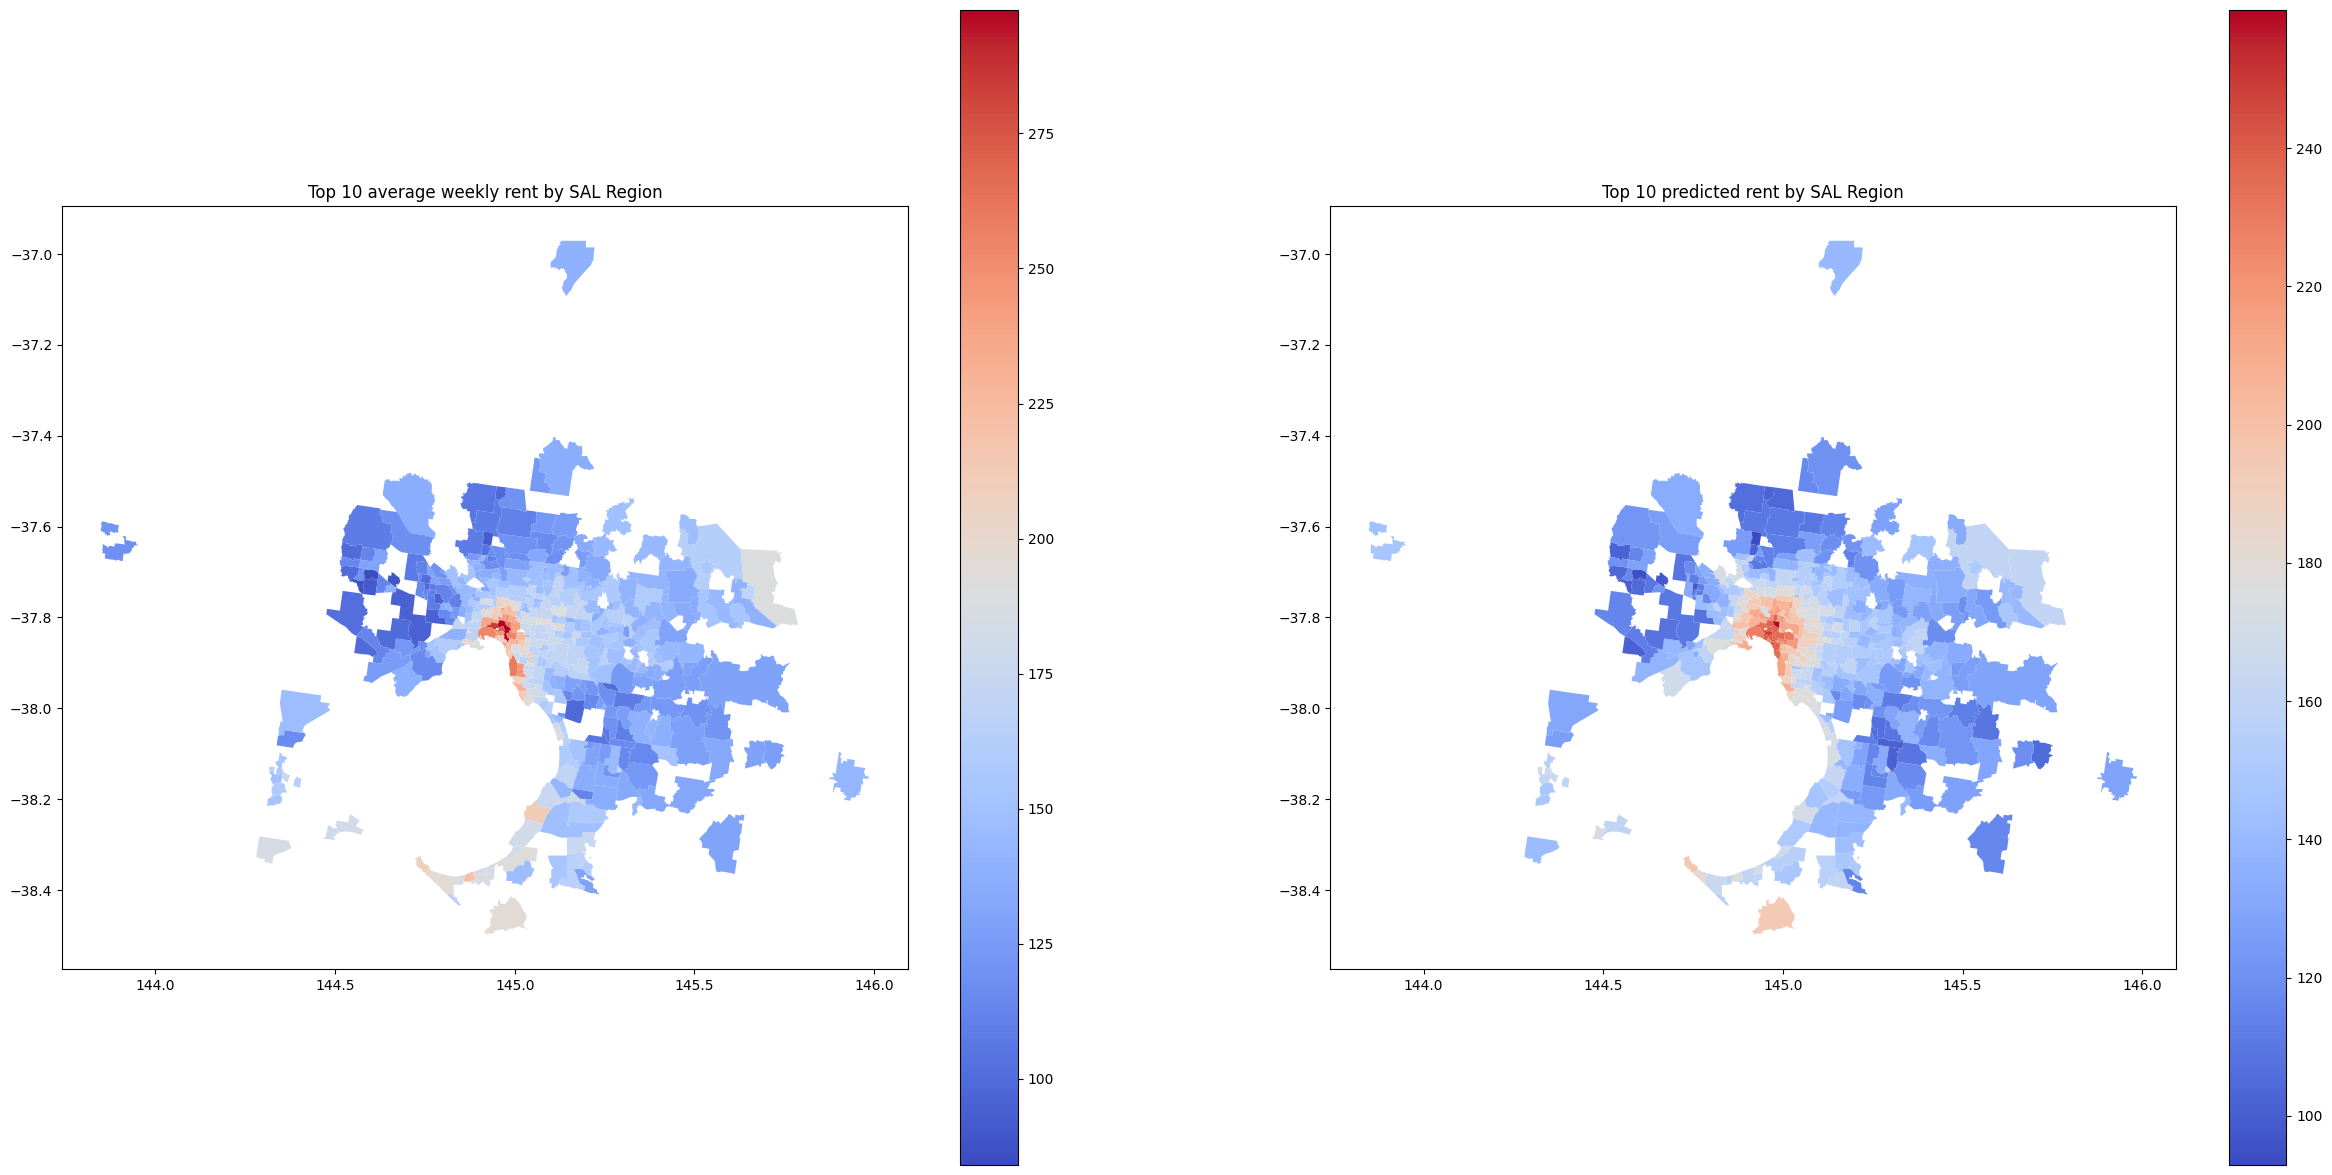

In [296]:

residuals_2023 = residuals_df[residuals_df["year"] == 2023]

# now make gdf

residuals_2023 = gpd.GeoDataFrame(residuals_2023, geometry='geometry')

# graph top 10 residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

residuals_2023.plot(column='average_weekly_rent', ax=ax1, legend=True, cmap='coolwarm')
ax1.set_title('Top 10 average weekly rent by SAL Region')

residuals_2023.plot(column='predicted_rent_xg', ax=ax2, legend=True, cmap='coolwarm')
ax2.set_title('Top 10 predicted rent by SAL Region')

plt.show()


In [297]:
# Filter the data for the years 2018 to 2023 (inclusive)
filtered_df = residuals_df[residuals_df['year'].isin(range(2017,2019))]

# Ensure the data is sorted by year within each group for accurate calculations
filtered_df = filtered_df.sort_values(by=['SAL_CODE', 'year'])

# Calculate the growth in average weekly rent over the last 5 years for each suburb
filtered_df['growth_actual'] = filtered_df.groupby('SAL_CODE')['average_weekly_rent'].transform(
    lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100 if len(x) > 1 else 0
)
filtered_df['growth_predicted'] = filtered_df.groupby('SAL_CODE')['predicted_rent_xg'].transform(
    lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100 if len(x) > 1 else 0
)

# Drop duplicates to get one entry per suburb
suburb_growth_actual = filtered_df.drop_duplicates(subset='SAL_CODE', keep='last')
suburb_growth_predicted = filtered_df.drop_duplicates(subset='SAL_CODE', keep='last')

# Sort the suburbs by the highest growth in actual and predicted rents
highest_growth_actual = suburb_growth_actual.sort_values(by='growth_actual', ascending=False)
highest_growth_predicted = suburb_growth_predicted.sort_values(by='growth_predicted', ascending=False)

# Display the top suburbs with the highest growth
print("Suburbs with the highest growth in actual average weekly rent over the last 5 years:")
print(highest_growth_actual[['SAL_NAME21', 'growth_actual']][:10])

print("\nSuburbs with the highest growth in predicted average weekly rent over the last 5 years:")
print(highest_growth_predicted[['SAL_NAME21', 'growth_predicted']])


Suburbs with the highest growth in actual average weekly rent over the last 5 years:
             SAL_NAME21  growth_actual
668     Armadale (Vic.)       8.546635
272     Box Hill (Vic.)       7.314161
731           Docklands       6.415036
281      Box Hill North       6.293236
290      Box Hill South       6.293236
1631          Thornbury       6.126911
1928             Keilor       5.839099
407    Glen Iris (Vic.)       5.656876
326   Camberwell (Vic.)       5.626319
2198     Seymour (Vic.)       5.567865

Suburbs with the highest growth in predicted average weekly rent over the last 5 years:
            SAL_NAME21  growth_predicted
3584         Dandenong          9.945009
3368    Werribee South          6.809154
3971          Carnegie          6.417063
4169       Murrumbeena          6.204837
3872  Springvale South          5.799095
...                ...               ...
2945        Cobblebank         -3.836361
3323    Thornhill Park         -3.914265
3251      Strathtulloh      

In [298]:
highest_growth_predicted[highest_growth_predicted["SAL_NAME21"] == 'Melbourne']

SAL_CODE  year  residuals  xg_residuals  average_weekly_rent  SAL_CODE21  \
794   21640.0  2018  51.323954     16.184687           257.038859       21640   

    SAL_NAME21 STE_CODE21 STE_NAME21 AUS_CODE21  ... AREASQKM21  \
794  Melbourne          2   Victoria        AUS  ...     6.5866   

                                            LOCI_URI21 SHAPE_Leng  SHAPE_Area  \
794  http://linked.data.gov.au/dataset/asgsed3/SAL/...    0.21602    0.000674   

                                              geometry distance_to_CBD  \
794  POLYGON ((144.96885 -37.80728, 144.97094 -37.8...        1.458285   

     predicted_rent  predicted_rent_xg  growth_actual  growth_predicted  
794      205.714905         240.854173       5.259754          4.618404  

[1 rows x 21 columns]

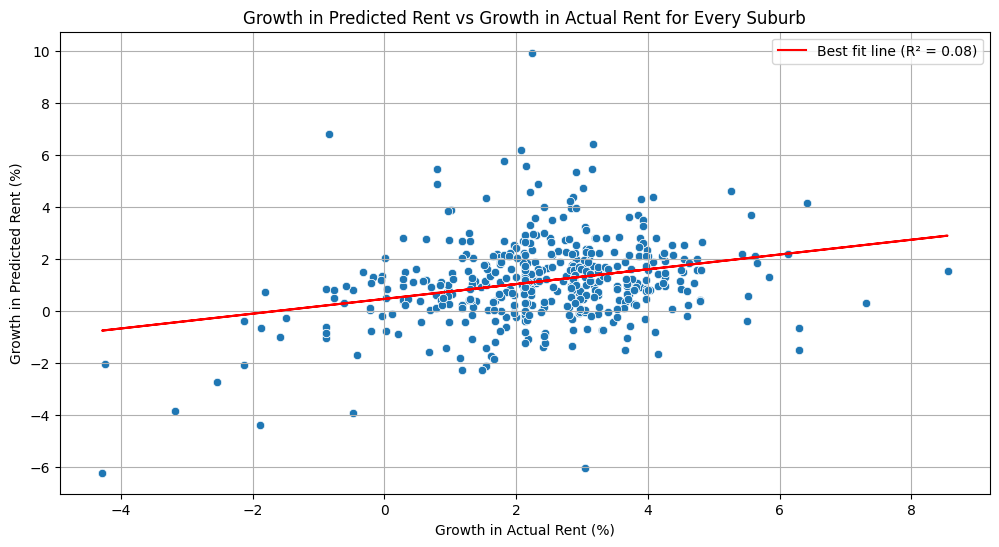

In [299]:
from scipy.stats import linregress

# Scatter plot of growth in predicted rent vs growth in actual rent for every suburb
plt.figure(figsize=(12, 6))
sns.scatterplot(x='growth_actual', y='growth_predicted', data=filtered_df)

# Calculate the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(filtered_df['growth_actual'], filtered_df['growth_predicted'])
line = slope * filtered_df['growth_actual'] + intercept

# Plot the line of best fit
plt.plot(filtered_df['growth_actual'], line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

plt.title('Growth in Predicted Rent vs Growth in Actual Rent for Every Suburb')
plt.xlabel('Growth in Actual Rent (%)')
plt.ylabel('Growth in Predicted Rent (%)')
plt.legend()
plt.grid(True)
plt.show()

In [300]:
# compare actual and predicted rents for lg rf 
# Calculate the predicted values by subtracting residuals from actual values
residuals_df['predicted_rent'] = residuals_df['average_weekly_rent'] - residuals_df['residuals']

In [301]:
# find SAL code of 10 highest residuals
top_10_residuals = residuals_df.nlargest(10, 'residuals')[['SAL_CODE21', 'SAL_NAME21', 'residuals', 'year']]
print(top_10_residuals)

      SAL_CODE21       SAL_NAME21   residuals  year
3964       20338    Brighton East  121.324405  2020
3965       20338    Brighton East  112.099726  2021
3963       20338    Brighton East  110.535566  2019
3966       20338    Brighton East  109.515063  2022
800        21640        Melbourne  109.403841  2024
737        20766        Docklands  109.338114  2024
3962       20338    Brighton East  107.609951  2018
920        22345    St Kilda West  106.000477  2018
3955       20337  Brighton (Vic.)  105.524690  2020
921        22345    St Kilda West  104.489860  2019


In [302]:
# bottom 10 residuals
bottom_10_residuals = residuals_df.nsmallest(10, 'residuals')[['SAL_CODE21', 'SAL_NAME21', 'residuals', 'year']]
print(bottom_10_residuals)


      SAL_CODE21          SAL_NAME21  residuals  year
126        20640               Corio -42.488847  2016
127        20640               Corio -41.482045  2017
128        20640               Corio -37.311601  2018
129        20640               Corio -33.388939  2019
1251       22333    St Andrews Beach -32.776089  2016
3265       22395     Sunshine (Vic.) -30.901298  2023
144        20974        Geelong West -30.606703  2016
3184       22086          Point Cook -30.326941  2023
2032       22381  Strathmore Heights -30.045644  2023
134        20640               Corio -29.685445  2024


In [303]:
# find SAL code of 10 highest residuals
top_10_residuals = residuals_2023.nlargest(30, 'average_weekly_rent')[['SAL_NAME21', 'average_weekly_rent', 'year']]
print(top_10_residuals)

              SAL_NAME21  average_weekly_rent  year
799            Melbourne           297.853964  2023
736            Docklands           283.806867  2023
898            Southbank           273.256576  2023
745       East Melbourne           259.024463  2023
3958     Brighton (Vic.)           258.923577  2023
889          South Yarra           255.226960  2023
835       Port Melbourne           253.102285  2023
763       Fitzroy (Vic.)           248.072237  2023
880      South Melbourne           246.250570  2023
3967       Brighton East           245.383882  2023
691       Carlton (Vic.)           242.515211  2023
925        St Kilda West           242.148604  2023
727      Cremorne (Vic.)           240.399900  2023
862      Richmond (Vic.)           240.399900  2023
655    Abbotsford (Vic.)           240.070087  2023
853         Princes Hill           238.674508  2023
952       West Melbourne           236.990925  2023
718   Collingwood (Vic.)           234.934898  2023
844         

In [304]:
sal_to_exclude = pd.read_csv('../data/landing/filtered_sal_codes.csv')


In [305]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest Mean Squared Error: 136.5784208447555
Random Forest R^2 Score: 0.8989999602990453


In [306]:
# generate predictions from 2025-2028
